## Necessary imports

In [1]:
import math, re, os, sys
import numpy as np
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

!pip install -U scikit-learn

print("Tensorflow version " + tf.__version__)

D0512 16:06:01.167548024      13 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0512 16:06:01.167583120      13 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0512 16:06:01.167586924      13 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0512 16:06:01.167589784      13 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0512 16:06:01.167592384      13 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0512 16:06:01.167595679      13 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0512 16:06:01.167598430      13 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0512 16:06:01.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/9.8 MB ? eta -:--:--

     ━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.3/9.8 MB 8.2 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━ 6.5/9.8 MB 61.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 9.8/9.8 MB 76.7 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 52.6 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 23.7 MB/s eta 0:00:00


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


Tensorflow version 2.12.0


In [2]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None
    if 'GPU' in tf.test.gpu_device_name():
        print('Running on GPU', tf.test.gpu_device_name())
    else:
        print('Running on CPU')

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


REPLICAS:  8


In [3]:
from shutil import rmtree

try:
    rmtree("/kaggle/working/Neural-Networks-2023-Project")
except:
    print('No previous project folder found in working directory.')

! git clone https://github.com/m-tarro/Neural-Networks-2023-Project.git
sys.path.append('/kaggle/working/Neural-Networks-2023-Project/')

from utils.DataLoad import DataLoad
from utils.DataVisualization import DataVisualization

No previous project folder found in working directory.


Cloning into 'Neural-Networks-2023-Project'...


remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.


remote: Compressing objects: 100% (43/43), done.


remote: Total 53 (delta 17), reused 37 (delta 7), pack-reused 0
Receiving objects: 100% (53/53), 3.21 MiB | 30.44 MiB/s, done.
Resolving deltas: 100% (17/17), done.


# Model to implement

The data will load to data_load based on chosen `IMAGE_SIZE` and `BATCH_SIZE`. Then the model has to be compiled within `strategy.scope()`, compiled with chosen `optimizer`, `loss`, and `metrics`.

In [4]:
def data_augment(image, label):
    #data augmentation to prevent overfitting and to find more patterns.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_flip_up_down(image)
    image = tf.image.random_saturation(image, 0, 2)
    #image = tf.image.random_brightness(image, 0.2)
    return image, label

In [5]:
image_size = 224
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

IMAGE_SIZE = [image_size, image_size]

data_load = DataLoad(image_size=image_size, batch_size=BATCH_SIZE)
data_vis = DataVisualization(data_load)

ds_train = data_load.get_training_dataset(data_augment=data_augment)
ds_valid = data_load.get_validation_dataset()
ds_test = data_load.get_test_dataset()

get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/tpu-getting-started


In [6]:
"""
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten

gu_seed = tf.keras.initializers.GlorotUniform(seed=1)

with strategy.scope():
    pretrained_model = tf.keras.applications.vgg16.VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=[*IMAGE_SIZE, 3],
        classes=len(data_load.CLASSES),
        classifier_activation='softmax'
    )
    pretrained_model.trainable = False
    
    for layer in pretrained_model.layers[15:]:
        layer.trainable = True
    
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(len(data_load.CLASSES), activation='softmax')
    ])
"""

"\nfrom tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten\n\ngu_seed = tf.keras.initializers.GlorotUniform(seed=1)\n\nwith strategy.scope():\n    pretrained_model = tf.keras.applications.vgg16.VGG16(\n        weights='imagenet',\n        include_top=False,\n        input_shape=[*IMAGE_SIZE, 3],\n        classes=len(data_load.CLASSES),\n        classifier_activation='softmax'\n    )\n    pretrained_model.trainable = False\n    \n    for layer in pretrained_model.layers[15:]:\n        layer.trainable = True\n    \n    model = tf.keras.Sequential([\n        pretrained_model,\n        tf.keras.layers.GlobalAveragePooling2D(),\n        tf.keras.layers.BatchNormalization(),  \n        tf.keras.layers.Dropout(0.25),\n        tf.keras.layers.Dense(len(data_load.CLASSES), activation='softmax')\n    ])\n"

In [7]:
from tensorflow.keras import layers, callbacks

with strategy.scope():
#     pretrained_model = tf.keras.applications.InceptionResNetV2(
#     weights = 'imagenet', 
#     include_top = False, 
#     input_shape = [*IMAGE_SIZE, 3])

#     pretrained_model = tf.keras.applications.MobileNetV2(
#         weights = 'imagenet', 
#         include_top = False, 
#         input_shape = [*IMAGE_SIZE, 3])
    
#     pretrained_model = tf.keras.applications.ResNet152V2(
#         weights = 'imagenet', 
#         include_top = False, 
#         input_shape = [*IMAGE_SIZE, 3])
    
#     pretrained_model = tf.keras.applications.InceptionV3(
#         weights = 'imagenet', 
#         include_top = False, 
#         input_shape = [*IMAGE_SIZE, 3])
    
#     pretrained_model = efficientnet.EfficientNetB7(
#         weights = 'noisy-student', 
#         include_top = False, 
#         input_shape = [*IMAGE_SIZE, 3])
    
    pretrained_model = tf.keras.applications.DenseNet201(
        weights = 'imagenet', 
        include_top = False, 
        input_shape = [*IMAGE_SIZE, 3])
        
#     pretrained_model = tf.keras.applications.xception.Xception(
#         weights='imagenet',
#         include_top=False ,
#         input_shape=[*IMAGE_SIZE, 3]
#     )

    pretrained_model.trainable = True
    
    model = tf.keras.Sequential([        
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(data_load.CLASSES), activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'],
    )

    8192/74836368 [..............................] - ETA: 0s

 4202496/74836368 [>.............................] - ETA: 1s

14491648/74836368 [====>.........................] - ETA: 0s

25141248/74836368 [=========>....................] - ETA: 0s

35094528/74836368 [=============>................] - ETA: 0s

45694976/74836368 [=================>............] - ETA: 0s

55033856/74836368 [=====================>........] - ETA: 0s

63553536/74836368 [========================>.....] - ETA: 0s

72032256/74836368 [===========================>..] - ETA: 0s

74836368/74836368 [==============================] - 0s 0us/step


In [8]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.005, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model_name = 'densenet201_minAug'

model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  


 global_average_pooling2d (G  (None, 1920)             0         


 lobalAveragePooling2D)                                          


 dense (Dense)               (None, 104)               199784    


Total params: 18,521,768


Trainable params: 18,292,712


Non-trainable params: 229,056


_________________________________________________________________


Now it is possible to augment the images within `data_augment` function, pick the number of `EPOCHS`, and fit the model.

### Augmentation visualisation

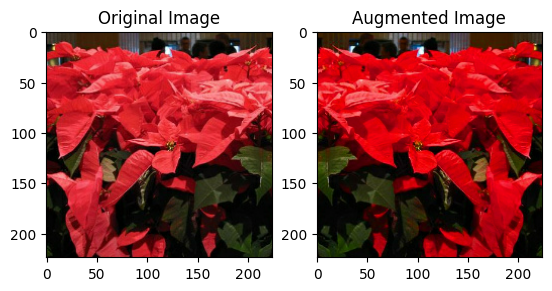

In [9]:
from itertools import islice
import matplotlib.pyplot as plt

ds_train_original = data_load.get_training_dataset(data_augment = False, ordered = True)
ds_train_no_augment = ds_train_original.take(1).cache().repeat()
ds_train_augment = ds_train_no_augment.map(data_augment)

index = 1 # Use the same index for both datasets
augmented_images, labels = next(islice(ds_train_augment, index, None))
original_images, labels = next(islice(ds_train_no_augment, index, None))

fig, axes = plt.subplots(ncols=2)
axes[0].imshow(original_images[0].numpy())
axes[0].set_title("Original Image")
axes[1].imshow(augmented_images[0].numpy())
axes[1].set_title("Augmented Image")
plt.show()

## Training

In [10]:
EPOCHS = 30
STEPS_PER_EPOCH = data_load.TRAINING_STEPS_PER_EPOCH

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    #callbacks=[lr_callback, early_stopping],
    callbacks=[early_stopping]
    #class_weight = weight_per_class #tuning11
)

Epoch 1/30


2023-05-12 16:09:02.160496: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


2023-05-12 16:09:04.730289: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


 1/99 [..............................] - ETA: 5:20:54 - loss: 5.0377 - sparse_categorical_accuracy: 0.0078

 2/99 [..............................] - ETA: 19s - loss: 4.5372 - sparse_categorical_accuracy: 0.0859    

 3/99 [..............................] - ETA: 18s - loss: 4.2001 - sparse_categorical_accuracy: 0.1432

 4/99 [>.............................] - ETA: 18s - loss: 4.0406 - sparse_categorical_accuracy: 0.1758

 5/99 [>.............................] - ETA: 18s - loss: 3.9304 - sparse_categorical_accuracy: 0.1891

 6/99 [>.............................] - ETA: 17s - loss: 3.8056 - sparse_categorical_accuracy: 0.2109

 7/99 [=>............................] - ETA: 17s - loss: 3.7057 - sparse_categorical_accuracy: 0.2254

 8/99 [=>............................] - ETA: 17s - loss: 3.5712 - sparse_categorical_accuracy: 0.2500

 9/99 [=>............................] - ETA: 17s - loss: 3.4870 - sparse_categorical_accuracy: 0.2682

10/99 [==>...........................] - ETA: 16s - loss: 3.3911 - sparse_categorical_accuracy: 0.2883

11/99 [==>...........................] - ETA: 16s - loss: 3.2857 - sparse_categorical_accuracy: 0.3089

12/99 [==>...........................] - ETA: 16s - loss: 3.2069 - sparse_categorical_accuracy: 0.3164

13/99 [==>...........................] - ETA: 16s - loss: 3.1553 - sparse_categorical_accuracy: 0.3275

14/99 [===>..........................] - ETA: 16s - loss: 3.0986 - sparse_categorical_accuracy: 0.3387

15/99 [===>..........................] - ETA: 15s - loss: 3.0342 - sparse_categorical_accuracy: 0.3495

16/99 [===>..........................] - ETA: 15s - loss: 2.9857 - sparse_categorical_accuracy: 0.3530

17/99 [====>.........................] - ETA: 15s - loss: 2.9559 - sparse_categorical_accuracy: 0.3608

18/99 [====>.........................] - ETA: 15s - loss: 2.9112 - sparse_categorical_accuracy: 0.3659

19/99 [====>.........................] - ETA: 15s - loss: 2.8703 - sparse_categorical_accuracy: 0.3713

20/99 [=====>........................] - ETA: 14s - loss: 2.8277 - sparse_categorical_accuracy: 0.3762

21/99 [=====>........................] - ETA: 14s - loss: 2.7828 - sparse_categorical_accuracy: 0.3850

22/99 [=====>........................] - ETA: 14s - loss: 2.7536 - sparse_categorical_accuracy: 0.3913

23/99 [=====>........................] - ETA: 14s - loss: 2.7197 - sparse_categorical_accuracy: 0.3971

24/99 [======>.......................] - ETA: 14s - loss: 2.6876 - sparse_categorical_accuracy: 0.4014

25/99 [======>.......................] - ETA: 13s - loss: 2.6517 - sparse_categorical_accuracy: 0.4075

26/99 [======>.......................] - ETA: 13s - loss: 2.6269 - sparse_categorical_accuracy: 0.4108

27/99 [=======>......................] - ETA: 13s - loss: 2.5930 - sparse_categorical_accuracy: 0.4146

28/99 [=======>......................] - ETA: 13s - loss: 2.5606 - sparse_categorical_accuracy: 0.4199

29/99 [=======>......................] - ETA: 13s - loss: 2.5363 - sparse_categorical_accuracy: 0.4232

30/99 [========>.....................] - ETA: 13s - loss: 2.5073 - sparse_categorical_accuracy: 0.4289

31/99 [========>.....................] - ETA: 12s - loss: 2.4778 - sparse_categorical_accuracy: 0.4360

32/99 [========>.....................] - ETA: 12s - loss: 2.4448 - sparse_categorical_accuracy: 0.4419

33/99 [=========>....................] - ETA: 12s - loss: 2.4158 - sparse_categorical_accuracy: 0.4470

34/99 [=========>....................] - ETA: 12s - loss: 2.3950 - sparse_categorical_accuracy: 0.4517

35/99 [=========>....................] - ETA: 12s - loss: 2.3664 - sparse_categorical_accuracy: 0.4574

36/99 [=========>....................] - ETA: 11s - loss: 2.3415 - sparse_categorical_accuracy: 0.4622

37/99 [==========>...................] - ETA: 11s - loss: 2.3144 - sparse_categorical_accuracy: 0.4668

38/99 [==========>...................] - ETA: 11s - loss: 2.2898 - sparse_categorical_accuracy: 0.4714

39/99 [==========>...................] - ETA: 11s - loss: 2.2688 - sparse_categorical_accuracy: 0.4750

40/99 [===========>..................] - ETA: 11s - loss: 2.2464 - sparse_categorical_accuracy: 0.4789

41/99 [===========>..................] - ETA: 10s - loss: 2.2295 - sparse_categorical_accuracy: 0.4819

42/99 [===========>..................] - ETA: 10s - loss: 2.2114 - sparse_categorical_accuracy: 0.4859

43/99 [============>.................] - ETA: 10s - loss: 2.1932 - sparse_categorical_accuracy: 0.4898

44/99 [============>.................] - ETA: 10s - loss: 2.1725 - sparse_categorical_accuracy: 0.4952

45/99 [============>.................] - ETA: 10s - loss: 2.1455 - sparse_categorical_accuracy: 0.5016

46/99 [============>.................] - ETA: 9s - loss: 2.1207 - sparse_categorical_accuracy: 0.5070 

47/99 [=============>................] - ETA: 9s - loss: 2.1062 - sparse_categorical_accuracy: 0.5090

48/99 [=============>................] - ETA: 9s - loss: 2.0931 - sparse_categorical_accuracy: 0.5109

49/99 [=============>................] - ETA: 9s - loss: 2.0764 - sparse_categorical_accuracy: 0.5136

50/99 [==============>...............] - ETA: 9s - loss: 2.0574 - sparse_categorical_accuracy: 0.5167

51/99 [==============>...............] - ETA: 8s - loss: 2.0449 - sparse_categorical_accuracy: 0.5185

52/99 [==============>...............] - ETA: 8s - loss: 2.0304 - sparse_categorical_accuracy: 0.5219

53/99 [===============>..............] - ETA: 8s - loss: 2.0185 - sparse_categorical_accuracy: 0.5246

54/99 [===============>..............] - ETA: 8s - loss: 2.0064 - sparse_categorical_accuracy: 0.5266

55/99 [===============>..............] - ETA: 8s - loss: 1.9935 - sparse_categorical_accuracy: 0.5293

56/99 [===============>..............] - ETA: 8s - loss: 1.9764 - sparse_categorical_accuracy: 0.5328

57/99 [================>.............] - ETA: 7s - loss: 1.9635 - sparse_categorical_accuracy: 0.5359

58/99 [================>.............] - ETA: 7s - loss: 1.9503 - sparse_categorical_accuracy: 0.5391

59/99 [================>.............] - ETA: 7s - loss: 1.9333 - sparse_categorical_accuracy: 0.5428

60/99 [=================>............] - ETA: 7s - loss: 1.9235 - sparse_categorical_accuracy: 0.5449

61/99 [=================>............] - ETA: 7s - loss: 1.9115 - sparse_categorical_accuracy: 0.5478

62/99 [=================>............] - ETA: 6s - loss: 1.8941 - sparse_categorical_accuracy: 0.5518

63/99 [==================>...........] - ETA: 6s - loss: 1.8820 - sparse_categorical_accuracy: 0.5546

64/99 [==================>...........] - ETA: 6s - loss: 1.8699 - sparse_categorical_accuracy: 0.5569

65/99 [==================>...........] - ETA: 6s - loss: 1.8600 - sparse_categorical_accuracy: 0.5588

66/99 [===================>..........] - ETA: 6s - loss: 1.8475 - sparse_categorical_accuracy: 0.5612

67/99 [===================>..........] - ETA: 5s - loss: 1.8351 - sparse_categorical_accuracy: 0.5639

68/99 [===================>..........] - ETA: 5s - loss: 1.8255 - sparse_categorical_accuracy: 0.5654

69/99 [===================>..........] - ETA: 5s - loss: 1.8168 - sparse_categorical_accuracy: 0.5677

70/99 [====================>.........] - ETA: 5s - loss: 1.8035 - sparse_categorical_accuracy: 0.5705

71/99 [====================>.........] - ETA: 5s - loss: 1.7938 - sparse_categorical_accuracy: 0.5716

72/99 [====================>.........] - ETA: 5s - loss: 1.7848 - sparse_categorical_accuracy: 0.5735

73/99 [=====================>........] - ETA: 4s - loss: 1.7751 - sparse_categorical_accuracy: 0.5753

74/99 [=====================>........] - ETA: 4s - loss: 1.7671 - sparse_categorical_accuracy: 0.5756

75/99 [=====================>........] - ETA: 4s - loss: 1.7568 - sparse_categorical_accuracy: 0.5778

76/99 [======================>.......] - ETA: 4s - loss: 1.7484 - sparse_categorical_accuracy: 0.5799

77/99 [======================>.......] - ETA: 4s - loss: 1.7412 - sparse_categorical_accuracy: 0.5813

78/99 [======================>.......] - ETA: 3s - loss: 1.7326 - sparse_categorical_accuracy: 0.5835

79/99 [======================>.......] - ETA: 3s - loss: 1.7249 - sparse_categorical_accuracy: 0.5853

80/99 [=======================>......] - ETA: 3s - loss: 1.7153 - sparse_categorical_accuracy: 0.5871

81/99 [=======================>......] - ETA: 3s - loss: 1.7077 - sparse_categorical_accuracy: 0.5883

82/99 [=======================>......] - ETA: 3s - loss: 1.6988 - sparse_categorical_accuracy: 0.5904

83/99 [========================>.....] - ETA: 2s - loss: 1.6905 - sparse_categorical_accuracy: 0.5921

84/99 [========================>.....] - ETA: 2s - loss: 1.6815 - sparse_categorical_accuracy: 0.5937

85/99 [========================>.....] - ETA: 2s - loss: 1.6744 - sparse_categorical_accuracy: 0.5954

86/99 [=========================>....] - ETA: 2s - loss: 1.6660 - sparse_categorical_accuracy: 0.5972

87/99 [=========================>....] - ETA: 2s - loss: 1.6602 - sparse_categorical_accuracy: 0.5987

88/99 [=========================>....] - ETA: 2s - loss: 1.6530 - sparse_categorical_accuracy: 0.6008

89/99 [=========================>....] - ETA: 1s - loss: 1.6451 - sparse_categorical_accuracy: 0.6022

90/99 [==========================>...] - ETA: 1s - loss: 1.6417 - sparse_categorical_accuracy: 0.6026

91/99 [==========================>...] - ETA: 1s - loss: 1.6336 - sparse_categorical_accuracy: 0.6046

92/99 [==========================>...] - ETA: 1s - loss: 1.6276 - sparse_categorical_accuracy: 0.6056

93/99 [===========================>..] - ETA: 1s - loss: 1.6192 - sparse_categorical_accuracy: 0.6073

94/99 [===========================>..] - ETA: 0s - loss: 1.6131 - sparse_categorical_accuracy: 0.6088

95/99 [===========================>..] - ETA: 0s - loss: 1.6067 - sparse_categorical_accuracy: 0.6101

96/99 [============================>.] - ETA: 0s - loss: 1.5987 - sparse_categorical_accuracy: 0.6123

97/99 [============================>.] - ETA: 0s - loss: 1.5906 - sparse_categorical_accuracy: 0.6137

98/99 [============================>.] - ETA: 0s - loss: 1.5823 - sparse_categorical_accuracy: 0.6157

99/99 [==============================] - ETA: 0s - loss: 1.5781 - sparse_categorical_accuracy: 0.6161

2023-05-12 16:11:22.642676: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


2023-05-12 16:11:23.197435: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


99/99 [==============================] - 252s 570ms/step - loss: 1.5781 - sparse_categorical_accuracy: 0.6161 - val_loss: 3.9461 - val_sparse_categorical_accuracy: 0.2928


Epoch 2/30


 1/99 [..............................] - ETA: 18s - loss: 0.9812 - sparse_categorical_accuracy: 0.7422

 2/99 [..............................] - ETA: 19s - loss: 0.9009 - sparse_categorical_accuracy: 0.7500

 3/99 [..............................] - ETA: 18s - loss: 0.8701 - sparse_categorical_accuracy: 0.7526

 4/99 [>.............................] - ETA: 18s - loss: 0.8193 - sparse_categorical_accuracy: 0.7676

 5/99 [>.............................] - ETA: 18s - loss: 0.8079 - sparse_categorical_accuracy: 0.7750

 6/99 [>.............................] - ETA: 18s - loss: 0.8370 - sparse_categorical_accuracy: 0.7708

 7/99 [=>............................] - ETA: 17s - loss: 0.8554 - sparse_categorical_accuracy: 0.7712

 8/99 [=>............................] - ETA: 17s - loss: 0.8511 - sparse_categorical_accuracy: 0.7754

 9/99 [=>............................] - ETA: 17s - loss: 0.8418 - sparse_categorical_accuracy: 0.7830

10/99 [==>...........................] - ETA: 17s - loss: 0.8551 - sparse_categorical_accuracy: 0.7828

11/99 [==>...........................] - ETA: 16s - loss: 0.8569 - sparse_categorical_accuracy: 0.7784

12/99 [==>...........................] - ETA: 16s - loss: 0.8507 - sparse_categorical_accuracy: 0.7786

13/99 [==>...........................] - ETA: 16s - loss: 0.8250 - sparse_categorical_accuracy: 0.7897

14/99 [===>..........................] - ETA: 16s - loss: 0.8148 - sparse_categorical_accuracy: 0.7896

15/99 [===>..........................] - ETA: 15s - loss: 0.8018 - sparse_categorical_accuracy: 0.7922

16/99 [===>..........................] - ETA: 15s - loss: 0.8061 - sparse_categorical_accuracy: 0.7886

17/99 [====>.........................] - ETA: 15s - loss: 0.8072 - sparse_categorical_accuracy: 0.7872

18/99 [====>.........................] - ETA: 15s - loss: 0.8065 - sparse_categorical_accuracy: 0.7856

19/99 [====>.........................] - ETA: 14s - loss: 0.8168 - sparse_categorical_accuracy: 0.7841

20/99 [=====>........................] - ETA: 14s - loss: 0.8073 - sparse_categorical_accuracy: 0.7867

21/99 [=====>........................] - ETA: 14s - loss: 0.8004 - sparse_categorical_accuracy: 0.7891

22/99 [=====>........................] - ETA: 14s - loss: 0.8047 - sparse_categorical_accuracy: 0.7880

23/99 [=====>........................] - ETA: 14s - loss: 0.7989 - sparse_categorical_accuracy: 0.7901

24/99 [======>.......................] - ETA: 14s - loss: 0.7934 - sparse_categorical_accuracy: 0.7904

25/99 [======>.......................] - ETA: 13s - loss: 0.7882 - sparse_categorical_accuracy: 0.7909

26/99 [======>.......................] - ETA: 13s - loss: 0.7831 - sparse_categorical_accuracy: 0.7930

27/99 [=======>......................] - ETA: 13s - loss: 0.7789 - sparse_categorical_accuracy: 0.7946

28/99 [=======>......................] - ETA: 13s - loss: 0.7747 - sparse_categorical_accuracy: 0.7960

29/99 [=======>......................] - ETA: 13s - loss: 0.7748 - sparse_categorical_accuracy: 0.7966

30/99 [========>.....................] - ETA: 12s - loss: 0.7701 - sparse_categorical_accuracy: 0.7969

31/99 [========>.....................] - ETA: 12s - loss: 0.7741 - sparse_categorical_accuracy: 0.7954

32/99 [========>.....................] - ETA: 12s - loss: 0.7717 - sparse_categorical_accuracy: 0.7969

33/99 [=========>....................] - ETA: 12s - loss: 0.7722 - sparse_categorical_accuracy: 0.7964

34/99 [=========>....................] - ETA: 12s - loss: 0.7694 - sparse_categorical_accuracy: 0.7966

35/99 [=========>....................] - ETA: 11s - loss: 0.7650 - sparse_categorical_accuracy: 0.7975

36/99 [=========>....................] - ETA: 11s - loss: 0.7605 - sparse_categorical_accuracy: 0.7990

37/99 [==========>...................] - ETA: 11s - loss: 0.7599 - sparse_categorical_accuracy: 0.7990

38/99 [==========>...................] - ETA: 11s - loss: 0.7677 - sparse_categorical_accuracy: 0.7975

39/99 [==========>...................] - ETA: 11s - loss: 0.7674 - sparse_categorical_accuracy: 0.7971

40/99 [===========>..................] - ETA: 10s - loss: 0.7733 - sparse_categorical_accuracy: 0.7961

41/99 [===========>..................] - ETA: 10s - loss: 0.7732 - sparse_categorical_accuracy: 0.7965

42/99 [===========>..................] - ETA: 10s - loss: 0.7733 - sparse_categorical_accuracy: 0.7959

43/99 [============>.................] - ETA: 10s - loss: 0.7723 - sparse_categorical_accuracy: 0.7969

44/99 [============>.................] - ETA: 10s - loss: 0.7723 - sparse_categorical_accuracy: 0.7965

45/99 [============>.................] - ETA: 10s - loss: 0.7724 - sparse_categorical_accuracy: 0.7969

46/99 [============>.................] - ETA: 9s - loss: 0.7703 - sparse_categorical_accuracy: 0.7972 

47/99 [=============>................] - ETA: 9s - loss: 0.7667 - sparse_categorical_accuracy: 0.7979

48/99 [=============>................] - ETA: 9s - loss: 0.7647 - sparse_categorical_accuracy: 0.7983

49/99 [=============>................] - ETA: 9s - loss: 0.7642 - sparse_categorical_accuracy: 0.7989

50/99 [==============>...............] - ETA: 9s - loss: 0.7641 - sparse_categorical_accuracy: 0.7989

51/99 [==============>...............] - ETA: 8s - loss: 0.7612 - sparse_categorical_accuracy: 0.8001

52/99 [==============>...............] - ETA: 8s - loss: 0.7596 - sparse_categorical_accuracy: 0.8006

53/99 [===============>..............] - ETA: 8s - loss: 0.7555 - sparse_categorical_accuracy: 0.8010

54/99 [===============>..............] - ETA: 8s - loss: 0.7544 - sparse_categorical_accuracy: 0.8012

55/99 [===============>..............] - ETA: 8s - loss: 0.7537 - sparse_categorical_accuracy: 0.8013

56/99 [===============>..............] - ETA: 7s - loss: 0.7535 - sparse_categorical_accuracy: 0.8016

57/99 [================>.............] - ETA: 7s - loss: 0.7526 - sparse_categorical_accuracy: 0.8015

58/99 [================>.............] - ETA: 7s - loss: 0.7500 - sparse_categorical_accuracy: 0.8021

59/99 [================>.............] - ETA: 7s - loss: 0.7474 - sparse_categorical_accuracy: 0.8022

60/99 [=================>............] - ETA: 7s - loss: 0.7449 - sparse_categorical_accuracy: 0.8033

61/99 [=================>............] - ETA: 7s - loss: 0.7410 - sparse_categorical_accuracy: 0.8039

62/99 [=================>............] - ETA: 6s - loss: 0.7407 - sparse_categorical_accuracy: 0.8032

63/99 [==================>...........] - ETA: 6s - loss: 0.7395 - sparse_categorical_accuracy: 0.8036

64/99 [==================>...........] - ETA: 6s - loss: 0.7369 - sparse_categorical_accuracy: 0.8044

65/99 [==================>...........] - ETA: 6s - loss: 0.7364 - sparse_categorical_accuracy: 0.8044

66/99 [===================>..........] - ETA: 6s - loss: 0.7347 - sparse_categorical_accuracy: 0.8053

67/99 [===================>..........] - ETA: 5s - loss: 0.7329 - sparse_categorical_accuracy: 0.8060

68/99 [===================>..........] - ETA: 5s - loss: 0.7312 - sparse_categorical_accuracy: 0.8065

69/99 [===================>..........] - ETA: 5s - loss: 0.7285 - sparse_categorical_accuracy: 0.8073

70/99 [====================>.........] - ETA: 5s - loss: 0.7233 - sparse_categorical_accuracy: 0.8088

71/99 [====================>.........] - ETA: 5s - loss: 0.7218 - sparse_categorical_accuracy: 0.8090

72/99 [====================>.........] - ETA: 5s - loss: 0.7214 - sparse_categorical_accuracy: 0.8091

73/99 [=====================>........] - ETA: 4s - loss: 0.7198 - sparse_categorical_accuracy: 0.8098

74/99 [=====================>........] - ETA: 4s - loss: 0.7180 - sparse_categorical_accuracy: 0.8106

75/99 [=====================>........] - ETA: 4s - loss: 0.7147 - sparse_categorical_accuracy: 0.8113

76/99 [======================>.......] - ETA: 4s - loss: 0.7113 - sparse_categorical_accuracy: 0.8122

77/99 [======================>.......] - ETA: 4s - loss: 0.7101 - sparse_categorical_accuracy: 0.8123

78/99 [======================>.......] - ETA: 3s - loss: 0.7106 - sparse_categorical_accuracy: 0.8118

79/99 [======================>.......] - ETA: 3s - loss: 0.7104 - sparse_categorical_accuracy: 0.8117

80/99 [=======================>......] - ETA: 3s - loss: 0.7099 - sparse_categorical_accuracy: 0.8122

81/99 [=======================>......] - ETA: 3s - loss: 0.7075 - sparse_categorical_accuracy: 0.8126

82/99 [=======================>......] - ETA: 3s - loss: 0.7078 - sparse_categorical_accuracy: 0.8123

83/99 [========================>.....] - ETA: 2s - loss: 0.7073 - sparse_categorical_accuracy: 0.8116

84/99 [========================>.....] - ETA: 2s - loss: 0.7078 - sparse_categorical_accuracy: 0.8113

85/99 [========================>.....] - ETA: 2s - loss: 0.7057 - sparse_categorical_accuracy: 0.8116

86/99 [=========================>....] - ETA: 2s - loss: 0.7036 - sparse_categorical_accuracy: 0.8122

87/99 [=========================>....] - ETA: 2s - loss: 0.7039 - sparse_categorical_accuracy: 0.8121

88/99 [=========================>....] - ETA: 2s - loss: 0.7016 - sparse_categorical_accuracy: 0.8125

89/99 [=========================>....] - ETA: 1s - loss: 0.7004 - sparse_categorical_accuracy: 0.8126

90/99 [==========================>...] - ETA: 1s - loss: 0.6998 - sparse_categorical_accuracy: 0.8127

91/99 [==========================>...] - ETA: 1s - loss: 0.6989 - sparse_categorical_accuracy: 0.8131

92/99 [==========================>...] - ETA: 1s - loss: 0.6978 - sparse_categorical_accuracy: 0.8132

93/99 [===========================>..] - ETA: 1s - loss: 0.6963 - sparse_categorical_accuracy: 0.8138

94/99 [===========================>..] - ETA: 0s - loss: 0.6961 - sparse_categorical_accuracy: 0.8141

95/99 [===========================>..] - ETA: 0s - loss: 0.6944 - sparse_categorical_accuracy: 0.8146

96/99 [============================>.] - ETA: 0s - loss: 0.6936 - sparse_categorical_accuracy: 0.8147

97/99 [============================>.] - ETA: 0s - loss: 0.6940 - sparse_categorical_accuracy: 0.8148

98/99 [============================>.] - ETA: 0s - loss: 0.6926 - sparse_categorical_accuracy: 0.8148

99/99 [==============================] - ETA: 0s - loss: 0.6911 - sparse_categorical_accuracy: 0.8154

99/99 [==============================] - 24s 247ms/step - loss: 0.6911 - sparse_categorical_accuracy: 0.8154 - val_loss: 1.7658 - val_sparse_categorical_accuracy: 0.5814


Epoch 3/30


 1/99 [..............................] - ETA: 18s - loss: 0.5352 - sparse_categorical_accuracy: 0.8594

 2/99 [..............................] - ETA: 18s - loss: 0.5337 - sparse_categorical_accuracy: 0.8672

 3/99 [..............................] - ETA: 18s - loss: 0.5557 - sparse_categorical_accuracy: 0.8672

 4/99 [>.............................] - ETA: 17s - loss: 0.5619 - sparse_categorical_accuracy: 0.8652

 5/99 [>.............................] - ETA: 17s - loss: 0.5658 - sparse_categorical_accuracy: 0.8562

 6/99 [>.............................] - ETA: 17s - loss: 0.5875 - sparse_categorical_accuracy: 0.8516

 7/99 [=>............................] - ETA: 17s - loss: 0.5772 - sparse_categorical_accuracy: 0.8583

 8/99 [=>............................] - ETA: 17s - loss: 0.5934 - sparse_categorical_accuracy: 0.8564

 9/99 [=>............................] - ETA: 17s - loss: 0.5916 - sparse_categorical_accuracy: 0.8576

10/99 [==>...........................] - ETA: 16s - loss: 0.5815 - sparse_categorical_accuracy: 0.8547

11/99 [==>...........................] - ETA: 16s - loss: 0.5789 - sparse_categorical_accuracy: 0.8523

12/99 [==>...........................] - ETA: 16s - loss: 0.5819 - sparse_categorical_accuracy: 0.8490

13/99 [==>...........................] - ETA: 16s - loss: 0.5703 - sparse_categorical_accuracy: 0.8510

14/99 [===>..........................] - ETA: 15s - loss: 0.5674 - sparse_categorical_accuracy: 0.8549

15/99 [===>..........................] - ETA: 15s - loss: 0.5722 - sparse_categorical_accuracy: 0.8536

16/99 [===>..........................] - ETA: 15s - loss: 0.5729 - sparse_categorical_accuracy: 0.8516

17/99 [====>.........................] - ETA: 15s - loss: 0.5689 - sparse_categorical_accuracy: 0.8520

18/99 [====>.........................] - ETA: 15s - loss: 0.5745 - sparse_categorical_accuracy: 0.8507

19/99 [====>.........................] - ETA: 15s - loss: 0.5749 - sparse_categorical_accuracy: 0.8516

20/99 [=====>........................] - ETA: 14s - loss: 0.5759 - sparse_categorical_accuracy: 0.8516

21/99 [=====>........................] - ETA: 14s - loss: 0.5795 - sparse_categorical_accuracy: 0.8508

22/99 [=====>........................] - ETA: 14s - loss: 0.5712 - sparse_categorical_accuracy: 0.8537

23/99 [=====>........................] - ETA: 14s - loss: 0.5654 - sparse_categorical_accuracy: 0.8556

24/99 [======>.......................] - ETA: 14s - loss: 0.5700 - sparse_categorical_accuracy: 0.8525

25/99 [======>.......................] - ETA: 13s - loss: 0.5709 - sparse_categorical_accuracy: 0.8512

26/99 [======>.......................] - ETA: 13s - loss: 0.5737 - sparse_categorical_accuracy: 0.8510

27/99 [=======>......................] - ETA: 13s - loss: 0.5774 - sparse_categorical_accuracy: 0.8501

28/99 [=======>......................] - ETA: 13s - loss: 0.5744 - sparse_categorical_accuracy: 0.8507

29/99 [=======>......................] - ETA: 13s - loss: 0.5728 - sparse_categorical_accuracy: 0.8502

30/99 [========>.....................] - ETA: 12s - loss: 0.5708 - sparse_categorical_accuracy: 0.8487

31/99 [========>.....................] - ETA: 12s - loss: 0.5702 - sparse_categorical_accuracy: 0.8493

32/99 [========>.....................] - ETA: 12s - loss: 0.5665 - sparse_categorical_accuracy: 0.8503

33/99 [=========>....................] - ETA: 12s - loss: 0.5665 - sparse_categorical_accuracy: 0.8504

34/99 [=========>....................] - ETA: 12s - loss: 0.5685 - sparse_categorical_accuracy: 0.8493

35/99 [=========>....................] - ETA: 12s - loss: 0.5615 - sparse_categorical_accuracy: 0.8513

36/99 [=========>....................] - ETA: 11s - loss: 0.5557 - sparse_categorical_accuracy: 0.8531

37/99 [==========>...................] - ETA: 11s - loss: 0.5522 - sparse_categorical_accuracy: 0.8539

38/99 [==========>...................] - ETA: 11s - loss: 0.5481 - sparse_categorical_accuracy: 0.8549

39/99 [==========>...................] - ETA: 11s - loss: 0.5519 - sparse_categorical_accuracy: 0.8542

40/99 [===========>..................] - ETA: 11s - loss: 0.5537 - sparse_categorical_accuracy: 0.8535

41/99 [===========>..................] - ETA: 10s - loss: 0.5506 - sparse_categorical_accuracy: 0.8531

42/99 [===========>..................] - ETA: 10s - loss: 0.5520 - sparse_categorical_accuracy: 0.8531

43/99 [============>.................] - ETA: 10s - loss: 0.5522 - sparse_categorical_accuracy: 0.8534

44/99 [============>.................] - ETA: 10s - loss: 0.5533 - sparse_categorical_accuracy: 0.8532

45/99 [============>.................] - ETA: 10s - loss: 0.5572 - sparse_categorical_accuracy: 0.8530

46/99 [============>.................] - ETA: 9s - loss: 0.5540 - sparse_categorical_accuracy: 0.8539 

47/99 [=============>................] - ETA: 9s - loss: 0.5587 - sparse_categorical_accuracy: 0.8527

48/99 [=============>................] - ETA: 9s - loss: 0.5603 - sparse_categorical_accuracy: 0.8521

49/99 [=============>................] - ETA: 9s - loss: 0.5595 - sparse_categorical_accuracy: 0.8522

50/99 [==============>...............] - ETA: 9s - loss: 0.5583 - sparse_categorical_accuracy: 0.8527

51/99 [==============>...............] - ETA: 9s - loss: 0.5581 - sparse_categorical_accuracy: 0.8528

52/99 [==============>...............] - ETA: 8s - loss: 0.5588 - sparse_categorical_accuracy: 0.8526

53/99 [===============>..............] - ETA: 8s - loss: 0.5564 - sparse_categorical_accuracy: 0.8530

54/99 [===============>..............] - ETA: 8s - loss: 0.5554 - sparse_categorical_accuracy: 0.8527

55/99 [===============>..............] - ETA: 8s - loss: 0.5545 - sparse_categorical_accuracy: 0.8531

56/99 [===============>..............] - ETA: 8s - loss: 0.5516 - sparse_categorical_accuracy: 0.8537

57/99 [================>.............] - ETA: 7s - loss: 0.5498 - sparse_categorical_accuracy: 0.8540

58/99 [================>.............] - ETA: 7s - loss: 0.5480 - sparse_categorical_accuracy: 0.8545

59/99 [================>.............] - ETA: 7s - loss: 0.5483 - sparse_categorical_accuracy: 0.8543

60/99 [=================>............] - ETA: 7s - loss: 0.5493 - sparse_categorical_accuracy: 0.8542

61/99 [=================>............] - ETA: 7s - loss: 0.5471 - sparse_categorical_accuracy: 0.8548

62/99 [=================>............] - ETA: 6s - loss: 0.5442 - sparse_categorical_accuracy: 0.8556

63/99 [==================>...........] - ETA: 6s - loss: 0.5429 - sparse_categorical_accuracy: 0.8554

64/99 [==================>...........] - ETA: 6s - loss: 0.5411 - sparse_categorical_accuracy: 0.8557

65/99 [==================>...........] - ETA: 6s - loss: 0.5413 - sparse_categorical_accuracy: 0.8554

66/99 [===================>..........] - ETA: 6s - loss: 0.5407 - sparse_categorical_accuracy: 0.8554

67/99 [===================>..........] - ETA: 5s - loss: 0.5397 - sparse_categorical_accuracy: 0.8560

68/99 [===================>..........] - ETA: 5s - loss: 0.5398 - sparse_categorical_accuracy: 0.8558

69/99 [===================>..........] - ETA: 5s - loss: 0.5386 - sparse_categorical_accuracy: 0.8562

70/99 [====================>.........] - ETA: 5s - loss: 0.5365 - sparse_categorical_accuracy: 0.8569

71/99 [====================>.........] - ETA: 5s - loss: 0.5358 - sparse_categorical_accuracy: 0.8571

72/99 [====================>.........] - ETA: 5s - loss: 0.5323 - sparse_categorical_accuracy: 0.8580

73/99 [=====================>........] - ETA: 4s - loss: 0.5301 - sparse_categorical_accuracy: 0.8588

74/99 [=====================>........] - ETA: 4s - loss: 0.5292 - sparse_categorical_accuracy: 0.8587

75/99 [=====================>........] - ETA: 4s - loss: 0.5279 - sparse_categorical_accuracy: 0.8592

76/99 [======================>.......] - ETA: 4s - loss: 0.5274 - sparse_categorical_accuracy: 0.8596

77/99 [======================>.......] - ETA: 4s - loss: 0.5258 - sparse_categorical_accuracy: 0.8601

78/99 [======================>.......] - ETA: 3s - loss: 0.5253 - sparse_categorical_accuracy: 0.8601

79/99 [======================>.......] - ETA: 3s - loss: 0.5241 - sparse_categorical_accuracy: 0.8603

80/99 [=======================>......] - ETA: 3s - loss: 0.5244 - sparse_categorical_accuracy: 0.8596

81/99 [=======================>......] - ETA: 3s - loss: 0.5229 - sparse_categorical_accuracy: 0.8601

82/99 [=======================>......] - ETA: 3s - loss: 0.5212 - sparse_categorical_accuracy: 0.8605

83/99 [========================>.....] - ETA: 2s - loss: 0.5188 - sparse_categorical_accuracy: 0.8612

84/99 [========================>.....] - ETA: 2s - loss: 0.5177 - sparse_categorical_accuracy: 0.8611

85/99 [========================>.....] - ETA: 2s - loss: 0.5165 - sparse_categorical_accuracy: 0.8610

86/99 [=========================>....] - ETA: 2s - loss: 0.5152 - sparse_categorical_accuracy: 0.8616

87/99 [=========================>....] - ETA: 2s - loss: 0.5144 - sparse_categorical_accuracy: 0.8615

88/99 [=========================>....] - ETA: 2s - loss: 0.5154 - sparse_categorical_accuracy: 0.8612

89/99 [=========================>....] - ETA: 1s - loss: 0.5147 - sparse_categorical_accuracy: 0.8612

90/99 [==========================>...] - ETA: 1s - loss: 0.5150 - sparse_categorical_accuracy: 0.8611

91/99 [==========================>...] - ETA: 1s - loss: 0.5130 - sparse_categorical_accuracy: 0.8616

92/99 [==========================>...] - ETA: 1s - loss: 0.5122 - sparse_categorical_accuracy: 0.8619

93/99 [===========================>..] - ETA: 1s - loss: 0.5134 - sparse_categorical_accuracy: 0.8618

94/99 [===========================>..] - ETA: 0s - loss: 0.5121 - sparse_categorical_accuracy: 0.8620

95/99 [===========================>..] - ETA: 0s - loss: 0.5108 - sparse_categorical_accuracy: 0.8620

96/99 [============================>.] - ETA: 0s - loss: 0.5095 - sparse_categorical_accuracy: 0.8625

97/99 [============================>.] - ETA: 0s - loss: 0.5085 - sparse_categorical_accuracy: 0.8628

98/99 [============================>.] - ETA: 0s - loss: 0.5096 - sparse_categorical_accuracy: 0.8624

99/99 [==============================] - ETA: 0s - loss: 0.5087 - sparse_categorical_accuracy: 0.8626

99/99 [==============================] - 24s 248ms/step - loss: 0.5087 - sparse_categorical_accuracy: 0.8626 - val_loss: 1.1360 - val_sparse_categorical_accuracy: 0.6988


Epoch 4/30


 1/99 [..............................] - ETA: 17s - loss: 0.3323 - sparse_categorical_accuracy: 0.9297

 2/99 [..............................] - ETA: 18s - loss: 0.4116 - sparse_categorical_accuracy: 0.9141

 3/99 [..............................] - ETA: 17s - loss: 0.3758 - sparse_categorical_accuracy: 0.9141

 4/99 [>.............................] - ETA: 17s - loss: 0.4132 - sparse_categorical_accuracy: 0.9043

 5/99 [>.............................] - ETA: 17s - loss: 0.4283 - sparse_categorical_accuracy: 0.8938

 6/99 [>.............................] - ETA: 17s - loss: 0.4080 - sparse_categorical_accuracy: 0.8997

 7/99 [=>............................] - ETA: 16s - loss: 0.3987 - sparse_categorical_accuracy: 0.8984

 8/99 [=>............................] - ETA: 16s - loss: 0.4051 - sparse_categorical_accuracy: 0.8945

 9/99 [=>............................] - ETA: 16s - loss: 0.4168 - sparse_categorical_accuracy: 0.8906

10/99 [==>...........................] - ETA: 16s - loss: 0.4095 - sparse_categorical_accuracy: 0.8922

11/99 [==>...........................] - ETA: 15s - loss: 0.4134 - sparse_categorical_accuracy: 0.8920

12/99 [==>...........................] - ETA: 15s - loss: 0.4001 - sparse_categorical_accuracy: 0.8952

13/99 [==>...........................] - ETA: 15s - loss: 0.4014 - sparse_categorical_accuracy: 0.8942

14/99 [===>..........................] - ETA: 15s - loss: 0.3988 - sparse_categorical_accuracy: 0.8951

15/99 [===>..........................] - ETA: 15s - loss: 0.4024 - sparse_categorical_accuracy: 0.8932

16/99 [===>..........................] - ETA: 15s - loss: 0.4054 - sparse_categorical_accuracy: 0.8921

17/99 [====>.........................] - ETA: 14s - loss: 0.4039 - sparse_categorical_accuracy: 0.8929

18/99 [====>.........................] - ETA: 14s - loss: 0.4088 - sparse_categorical_accuracy: 0.8915

19/99 [====>.........................] - ETA: 14s - loss: 0.4050 - sparse_categorical_accuracy: 0.8935

20/99 [=====>........................] - ETA: 14s - loss: 0.4009 - sparse_categorical_accuracy: 0.8941

21/99 [=====>........................] - ETA: 14s - loss: 0.3951 - sparse_categorical_accuracy: 0.8955

22/99 [=====>........................] - ETA: 14s - loss: 0.3898 - sparse_categorical_accuracy: 0.8970

23/99 [=====>........................] - ETA: 13s - loss: 0.3855 - sparse_categorical_accuracy: 0.8984

24/99 [======>.......................] - ETA: 13s - loss: 0.3925 - sparse_categorical_accuracy: 0.8958

25/99 [======>.......................] - ETA: 13s - loss: 0.3922 - sparse_categorical_accuracy: 0.8956

26/99 [======>.......................] - ETA: 13s - loss: 0.3967 - sparse_categorical_accuracy: 0.8942

27/99 [=======>......................] - ETA: 13s - loss: 0.3944 - sparse_categorical_accuracy: 0.8941

28/99 [=======>......................] - ETA: 13s - loss: 0.3978 - sparse_categorical_accuracy: 0.8931

29/99 [=======>......................] - ETA: 12s - loss: 0.3942 - sparse_categorical_accuracy: 0.8941

30/99 [========>.....................] - ETA: 12s - loss: 0.3983 - sparse_categorical_accuracy: 0.8922

31/99 [========>.....................] - ETA: 12s - loss: 0.3975 - sparse_categorical_accuracy: 0.8926

32/99 [========>.....................] - ETA: 12s - loss: 0.3959 - sparse_categorical_accuracy: 0.8921

33/99 [=========>....................] - ETA: 12s - loss: 0.3906 - sparse_categorical_accuracy: 0.8935

34/99 [=========>....................] - ETA: 11s - loss: 0.3890 - sparse_categorical_accuracy: 0.8943

35/99 [=========>....................] - ETA: 11s - loss: 0.3858 - sparse_categorical_accuracy: 0.8955

36/99 [=========>....................] - ETA: 11s - loss: 0.3859 - sparse_categorical_accuracy: 0.8954

37/99 [==========>...................] - ETA: 11s - loss: 0.3870 - sparse_categorical_accuracy: 0.8951

38/99 [==========>...................] - ETA: 11s - loss: 0.3840 - sparse_categorical_accuracy: 0.8962

39/99 [==========>...................] - ETA: 11s - loss: 0.3854 - sparse_categorical_accuracy: 0.8958

40/99 [===========>..................] - ETA: 10s - loss: 0.3837 - sparse_categorical_accuracy: 0.8967

41/99 [===========>..................] - ETA: 10s - loss: 0.3829 - sparse_categorical_accuracy: 0.8967

42/99 [===========>..................] - ETA: 10s - loss: 0.3860 - sparse_categorical_accuracy: 0.8958

43/99 [============>.................] - ETA: 10s - loss: 0.3862 - sparse_categorical_accuracy: 0.8959

44/99 [============>.................] - ETA: 10s - loss: 0.3836 - sparse_categorical_accuracy: 0.8968

45/99 [============>.................] - ETA: 9s - loss: 0.3835 - sparse_categorical_accuracy: 0.8969 

46/99 [============>.................] - ETA: 9s - loss: 0.3817 - sparse_categorical_accuracy: 0.8972

47/99 [=============>................] - ETA: 9s - loss: 0.3803 - sparse_categorical_accuracy: 0.8976

48/99 [=============>................] - ETA: 9s - loss: 0.3789 - sparse_categorical_accuracy: 0.8981

49/99 [=============>................] - ETA: 9s - loss: 0.3772 - sparse_categorical_accuracy: 0.8986

50/99 [==============>...............] - ETA: 8s - loss: 0.3761 - sparse_categorical_accuracy: 0.8988

51/99 [==============>...............] - ETA: 8s - loss: 0.3803 - sparse_categorical_accuracy: 0.8972

52/99 [==============>...............] - ETA: 8s - loss: 0.3796 - sparse_categorical_accuracy: 0.8972

53/99 [===============>..............] - ETA: 8s - loss: 0.3802 - sparse_categorical_accuracy: 0.8970

54/99 [===============>..............] - ETA: 8s - loss: 0.3790 - sparse_categorical_accuracy: 0.8974

55/99 [===============>..............] - ETA: 8s - loss: 0.3798 - sparse_categorical_accuracy: 0.8964

56/99 [===============>..............] - ETA: 7s - loss: 0.3799 - sparse_categorical_accuracy: 0.8963

57/99 [================>.............] - ETA: 7s - loss: 0.3812 - sparse_categorical_accuracy: 0.8964

58/99 [================>.............] - ETA: 7s - loss: 0.3803 - sparse_categorical_accuracy: 0.8968

59/99 [================>.............] - ETA: 7s - loss: 0.3812 - sparse_categorical_accuracy: 0.8968

60/99 [=================>............] - ETA: 7s - loss: 0.3811 - sparse_categorical_accuracy: 0.8969

61/99 [=================>............] - ETA: 6s - loss: 0.3808 - sparse_categorical_accuracy: 0.8965

62/99 [=================>............] - ETA: 6s - loss: 0.3803 - sparse_categorical_accuracy: 0.8972

63/99 [==================>...........] - ETA: 6s - loss: 0.3788 - sparse_categorical_accuracy: 0.8973

64/99 [==================>...........] - ETA: 6s - loss: 0.3820 - sparse_categorical_accuracy: 0.8960

65/99 [==================>...........] - ETA: 6s - loss: 0.3807 - sparse_categorical_accuracy: 0.8960

66/99 [===================>..........] - ETA: 6s - loss: 0.3798 - sparse_categorical_accuracy: 0.8961

67/99 [===================>..........] - ETA: 5s - loss: 0.3780 - sparse_categorical_accuracy: 0.8965

68/99 [===================>..........] - ETA: 5s - loss: 0.3780 - sparse_categorical_accuracy: 0.8966

69/99 [===================>..........] - ETA: 5s - loss: 0.3777 - sparse_categorical_accuracy: 0.8967

70/99 [====================>.........] - ETA: 5s - loss: 0.3760 - sparse_categorical_accuracy: 0.8972

71/99 [====================>.........] - ETA: 5s - loss: 0.3756 - sparse_categorical_accuracy: 0.8973

72/99 [====================>.........] - ETA: 4s - loss: 0.3768 - sparse_categorical_accuracy: 0.8971

73/99 [=====================>........] - ETA: 4s - loss: 0.3765 - sparse_categorical_accuracy: 0.8973

74/99 [=====================>........] - ETA: 4s - loss: 0.3771 - sparse_categorical_accuracy: 0.8971

75/99 [=====================>........] - ETA: 4s - loss: 0.3743 - sparse_categorical_accuracy: 0.8976

76/99 [======================>.......] - ETA: 4s - loss: 0.3756 - sparse_categorical_accuracy: 0.8974

77/99 [======================>.......] - ETA: 4s - loss: 0.3771 - sparse_categorical_accuracy: 0.8973

78/99 [======================>.......] - ETA: 3s - loss: 0.3766 - sparse_categorical_accuracy: 0.8973

79/99 [======================>.......] - ETA: 3s - loss: 0.3749 - sparse_categorical_accuracy: 0.8979

80/99 [=======================>......] - ETA: 3s - loss: 0.3741 - sparse_categorical_accuracy: 0.8981

81/99 [=======================>......] - ETA: 3s - loss: 0.3718 - sparse_categorical_accuracy: 0.8991

82/99 [=======================>......] - ETA: 3s - loss: 0.3712 - sparse_categorical_accuracy: 0.8991

83/99 [========================>.....] - ETA: 2s - loss: 0.3700 - sparse_categorical_accuracy: 0.8994

84/99 [========================>.....] - ETA: 2s - loss: 0.3703 - sparse_categorical_accuracy: 0.8994

85/99 [========================>.....] - ETA: 2s - loss: 0.3695 - sparse_categorical_accuracy: 0.8994

86/99 [=========================>....] - ETA: 2s - loss: 0.3686 - sparse_categorical_accuracy: 0.8999

87/99 [=========================>....] - ETA: 2s - loss: 0.3684 - sparse_categorical_accuracy: 0.8999

88/99 [=========================>....] - ETA: 2s - loss: 0.3680 - sparse_categorical_accuracy: 0.8995

89/99 [=========================>....] - ETA: 1s - loss: 0.3661 - sparse_categorical_accuracy: 0.8998

90/99 [==========================>...] - ETA: 1s - loss: 0.3662 - sparse_categorical_accuracy: 0.8999

91/99 [==========================>...] - ETA: 1s - loss: 0.3649 - sparse_categorical_accuracy: 0.9002

92/99 [==========================>...] - ETA: 1s - loss: 0.3640 - sparse_categorical_accuracy: 0.9003

93/99 [===========================>..] - ETA: 1s - loss: 0.3627 - sparse_categorical_accuracy: 0.9005

94/99 [===========================>..] - ETA: 0s - loss: 0.3621 - sparse_categorical_accuracy: 0.9009

95/99 [===========================>..] - ETA: 0s - loss: 0.3616 - sparse_categorical_accuracy: 0.9012

96/99 [============================>.] - ETA: 0s - loss: 0.3600 - sparse_categorical_accuracy: 0.9018

97/99 [============================>.] - ETA: 0s - loss: 0.3588 - sparse_categorical_accuracy: 0.9023

98/99 [============================>.] - ETA: 0s - loss: 0.3587 - sparse_categorical_accuracy: 0.9023

99/99 [==============================] - ETA: 0s - loss: 0.3585 - sparse_categorical_accuracy: 0.9021

99/99 [==============================] - 24s 246ms/step - loss: 0.3585 - sparse_categorical_accuracy: 0.9021 - val_loss: 0.7812 - val_sparse_categorical_accuracy: 0.8060


Epoch 5/30


 1/99 [..............................] - ETA: 17s - loss: 0.3189 - sparse_categorical_accuracy: 0.9219

 2/99 [..............................] - ETA: 18s - loss: 0.3183 - sparse_categorical_accuracy: 0.9141

 3/99 [..............................] - ETA: 18s - loss: 0.3770 - sparse_categorical_accuracy: 0.9089

 4/99 [>.............................] - ETA: 18s - loss: 0.3768 - sparse_categorical_accuracy: 0.9121

 5/99 [>.............................] - ETA: 17s - loss: 0.3813 - sparse_categorical_accuracy: 0.9141

 6/99 [>.............................] - ETA: 17s - loss: 0.3638 - sparse_categorical_accuracy: 0.9115

 7/99 [=>............................] - ETA: 17s - loss: 0.3493 - sparse_categorical_accuracy: 0.9163

 8/99 [=>............................] - ETA: 17s - loss: 0.3555 - sparse_categorical_accuracy: 0.9121

 9/99 [=>............................] - ETA: 16s - loss: 0.3560 - sparse_categorical_accuracy: 0.9089

10/99 [==>...........................] - ETA: 16s - loss: 0.3567 - sparse_categorical_accuracy: 0.9062

11/99 [==>...........................] - ETA: 16s - loss: 0.3647 - sparse_categorical_accuracy: 0.9013

12/99 [==>...........................] - ETA: 15s - loss: 0.3689 - sparse_categorical_accuracy: 0.9017

13/99 [==>...........................] - ETA: 15s - loss: 0.3631 - sparse_categorical_accuracy: 0.9038

14/99 [===>..........................] - ETA: 15s - loss: 0.3553 - sparse_categorical_accuracy: 0.9051

15/99 [===>..........................] - ETA: 15s - loss: 0.3632 - sparse_categorical_accuracy: 0.9005

16/99 [===>..........................] - ETA: 15s - loss: 0.3550 - sparse_categorical_accuracy: 0.9019

17/99 [====>.........................] - ETA: 15s - loss: 0.3519 - sparse_categorical_accuracy: 0.9035

18/99 [====>.........................] - ETA: 14s - loss: 0.3440 - sparse_categorical_accuracy: 0.9054

19/99 [====>.........................] - ETA: 14s - loss: 0.3402 - sparse_categorical_accuracy: 0.9067

20/99 [=====>........................] - ETA: 14s - loss: 0.3369 - sparse_categorical_accuracy: 0.9078

21/99 [=====>........................] - ETA: 14s - loss: 0.3358 - sparse_categorical_accuracy: 0.9070

22/99 [=====>........................] - ETA: 14s - loss: 0.3337 - sparse_categorical_accuracy: 0.9073

23/99 [=====>........................] - ETA: 13s - loss: 0.3359 - sparse_categorical_accuracy: 0.9066

24/99 [======>.......................] - ETA: 13s - loss: 0.3286 - sparse_categorical_accuracy: 0.9089

25/99 [======>.......................] - ETA: 13s - loss: 0.3302 - sparse_categorical_accuracy: 0.9087

26/99 [======>.......................] - ETA: 13s - loss: 0.3286 - sparse_categorical_accuracy: 0.9084

27/99 [=======>......................] - ETA: 13s - loss: 0.3266 - sparse_categorical_accuracy: 0.9091

28/99 [=======>......................] - ETA: 12s - loss: 0.3256 - sparse_categorical_accuracy: 0.9082

29/99 [=======>......................] - ETA: 12s - loss: 0.3267 - sparse_categorical_accuracy: 0.9081

30/99 [========>.....................] - ETA: 12s - loss: 0.3240 - sparse_categorical_accuracy: 0.9083

31/99 [========>.....................] - ETA: 12s - loss: 0.3237 - sparse_categorical_accuracy: 0.9090

32/99 [========>.....................] - ETA: 12s - loss: 0.3230 - sparse_categorical_accuracy: 0.9094

33/99 [=========>....................] - ETA: 11s - loss: 0.3248 - sparse_categorical_accuracy: 0.9089

34/99 [=========>....................] - ETA: 11s - loss: 0.3235 - sparse_categorical_accuracy: 0.9092

35/99 [=========>....................] - ETA: 11s - loss: 0.3246 - sparse_categorical_accuracy: 0.9087

36/99 [=========>....................] - ETA: 11s - loss: 0.3224 - sparse_categorical_accuracy: 0.9097

37/99 [==========>...................] - ETA: 11s - loss: 0.3216 - sparse_categorical_accuracy: 0.9101

38/99 [==========>...................] - ETA: 11s - loss: 0.3218 - sparse_categorical_accuracy: 0.9095

39/99 [==========>...................] - ETA: 10s - loss: 0.3225 - sparse_categorical_accuracy: 0.9089

40/99 [===========>..................] - ETA: 10s - loss: 0.3191 - sparse_categorical_accuracy: 0.9100

41/99 [===========>..................] - ETA: 10s - loss: 0.3188 - sparse_categorical_accuracy: 0.9099

42/99 [===========>..................] - ETA: 10s - loss: 0.3162 - sparse_categorical_accuracy: 0.9103

43/99 [============>.................] - ETA: 10s - loss: 0.3156 - sparse_categorical_accuracy: 0.9104

44/99 [============>.................] - ETA: 9s - loss: 0.3160 - sparse_categorical_accuracy: 0.9102 

45/99 [============>.................] - ETA: 9s - loss: 0.3190 - sparse_categorical_accuracy: 0.9085

46/99 [============>.................] - ETA: 9s - loss: 0.3191 - sparse_categorical_accuracy: 0.9086

47/99 [=============>................] - ETA: 9s - loss: 0.3164 - sparse_categorical_accuracy: 0.9094

48/99 [=============>................] - ETA: 9s - loss: 0.3173 - sparse_categorical_accuracy: 0.9092

49/99 [=============>................] - ETA: 9s - loss: 0.3154 - sparse_categorical_accuracy: 0.9098

50/99 [==============>...............] - ETA: 8s - loss: 0.3141 - sparse_categorical_accuracy: 0.9098

51/99 [==============>...............] - ETA: 8s - loss: 0.3142 - sparse_categorical_accuracy: 0.9101

52/99 [==============>...............] - ETA: 8s - loss: 0.3135 - sparse_categorical_accuracy: 0.9106

53/99 [===============>..............] - ETA: 8s - loss: 0.3148 - sparse_categorical_accuracy: 0.9102

54/99 [===============>..............] - ETA: 8s - loss: 0.3129 - sparse_categorical_accuracy: 0.9107

55/99 [===============>..............] - ETA: 7s - loss: 0.3132 - sparse_categorical_accuracy: 0.9104

56/99 [===============>..............] - ETA: 7s - loss: 0.3158 - sparse_categorical_accuracy: 0.9090

57/99 [================>.............] - ETA: 7s - loss: 0.3146 - sparse_categorical_accuracy: 0.9095

58/99 [================>.............] - ETA: 7s - loss: 0.3134 - sparse_categorical_accuracy: 0.9102

59/99 [================>.............] - ETA: 7s - loss: 0.3121 - sparse_categorical_accuracy: 0.9108

60/99 [=================>............] - ETA: 7s - loss: 0.3092 - sparse_categorical_accuracy: 0.9117

61/99 [=================>............] - ETA: 6s - loss: 0.3083 - sparse_categorical_accuracy: 0.9125

62/99 [=================>............] - ETA: 6s - loss: 0.3072 - sparse_categorical_accuracy: 0.9129

63/99 [==================>...........] - ETA: 6s - loss: 0.3056 - sparse_categorical_accuracy: 0.9136

64/99 [==================>...........] - ETA: 6s - loss: 0.3061 - sparse_categorical_accuracy: 0.9137

65/99 [==================>...........] - ETA: 6s - loss: 0.3055 - sparse_categorical_accuracy: 0.9139

66/99 [===================>..........] - ETA: 5s - loss: 0.3055 - sparse_categorical_accuracy: 0.9139

67/99 [===================>..........] - ETA: 5s - loss: 0.3059 - sparse_categorical_accuracy: 0.9136

68/99 [===================>..........] - ETA: 5s - loss: 0.3066 - sparse_categorical_accuracy: 0.9135

69/99 [===================>..........] - ETA: 5s - loss: 0.3049 - sparse_categorical_accuracy: 0.9141

70/99 [====================>.........] - ETA: 5s - loss: 0.3052 - sparse_categorical_accuracy: 0.9138

71/99 [====================>.........] - ETA: 5s - loss: 0.3048 - sparse_categorical_accuracy: 0.9141

72/99 [====================>.........] - ETA: 4s - loss: 0.3028 - sparse_categorical_accuracy: 0.9146

73/99 [=====================>........] - ETA: 4s - loss: 0.3037 - sparse_categorical_accuracy: 0.9142

74/99 [=====================>........] - ETA: 4s - loss: 0.3031 - sparse_categorical_accuracy: 0.9142

75/99 [=====================>........] - ETA: 4s - loss: 0.3047 - sparse_categorical_accuracy: 0.9137

76/99 [======================>.......] - ETA: 4s - loss: 0.3035 - sparse_categorical_accuracy: 0.9141

77/99 [======================>.......] - ETA: 3s - loss: 0.3032 - sparse_categorical_accuracy: 0.9145

78/99 [======================>.......] - ETA: 3s - loss: 0.3034 - sparse_categorical_accuracy: 0.9145

79/99 [======================>.......] - ETA: 3s - loss: 0.3018 - sparse_categorical_accuracy: 0.9148

80/99 [=======================>......] - ETA: 3s - loss: 0.3007 - sparse_categorical_accuracy: 0.9151

81/99 [=======================>......] - ETA: 3s - loss: 0.2997 - sparse_categorical_accuracy: 0.9154

82/99 [=======================>......] - ETA: 3s - loss: 0.2991 - sparse_categorical_accuracy: 0.9151

83/99 [========================>.....] - ETA: 2s - loss: 0.2984 - sparse_categorical_accuracy: 0.9151

84/99 [========================>.....] - ETA: 2s - loss: 0.2975 - sparse_categorical_accuracy: 0.9153

85/99 [========================>.....] - ETA: 2s - loss: 0.2967 - sparse_categorical_accuracy: 0.9157

86/99 [=========================>....] - ETA: 2s - loss: 0.2968 - sparse_categorical_accuracy: 0.9158

87/99 [=========================>....] - ETA: 2s - loss: 0.2978 - sparse_categorical_accuracy: 0.9158

88/99 [=========================>....] - ETA: 1s - loss: 0.2973 - sparse_categorical_accuracy: 0.9161

89/99 [=========================>....] - ETA: 1s - loss: 0.2964 - sparse_categorical_accuracy: 0.9162

90/99 [==========================>...] - ETA: 1s - loss: 0.2970 - sparse_categorical_accuracy: 0.9161

91/99 [==========================>...] - ETA: 1s - loss: 0.2963 - sparse_categorical_accuracy: 0.9165

92/99 [==========================>...] - ETA: 1s - loss: 0.2954 - sparse_categorical_accuracy: 0.9169

93/99 [===========================>..] - ETA: 1s - loss: 0.2958 - sparse_categorical_accuracy: 0.9167

94/99 [===========================>..] - ETA: 0s - loss: 0.2957 - sparse_categorical_accuracy: 0.9169

95/99 [===========================>..] - ETA: 0s - loss: 0.2970 - sparse_categorical_accuracy: 0.9166

96/99 [============================>.] - ETA: 0s - loss: 0.2975 - sparse_categorical_accuracy: 0.9163

97/99 [============================>.] - ETA: 0s - loss: 0.2967 - sparse_categorical_accuracy: 0.9165

98/99 [============================>.] - ETA: 0s - loss: 0.2967 - sparse_categorical_accuracy: 0.9165

99/99 [==============================] - ETA: 0s - loss: 0.2971 - sparse_categorical_accuracy: 0.9165

99/99 [==============================] - 21s 209ms/step - loss: 0.2971 - sparse_categorical_accuracy: 0.9165 - val_loss: 0.9484 - val_sparse_categorical_accuracy: 0.7592


Epoch 6/30


 1/99 [..............................] - ETA: 17s - loss: 0.3030 - sparse_categorical_accuracy: 0.9062

 2/99 [..............................] - ETA: 17s - loss: 0.3114 - sparse_categorical_accuracy: 0.9023

 3/99 [..............................] - ETA: 17s - loss: 0.2643 - sparse_categorical_accuracy: 0.9219

 4/99 [>.............................] - ETA: 17s - loss: 0.2827 - sparse_categorical_accuracy: 0.9180

 5/99 [>.............................] - ETA: 17s - loss: 0.2946 - sparse_categorical_accuracy: 0.9203

 6/99 [>.............................] - ETA: 16s - loss: 0.2817 - sparse_categorical_accuracy: 0.9232

 7/99 [=>............................] - ETA: 16s - loss: 0.2903 - sparse_categorical_accuracy: 0.9185

 8/99 [=>............................] - ETA: 16s - loss: 0.2865 - sparse_categorical_accuracy: 0.9189

 9/99 [=>............................] - ETA: 16s - loss: 0.2704 - sparse_categorical_accuracy: 0.9245

10/99 [==>...........................] - ETA: 16s - loss: 0.2670 - sparse_categorical_accuracy: 0.9242

11/99 [==>...........................] - ETA: 15s - loss: 0.2657 - sparse_categorical_accuracy: 0.9254

12/99 [==>...........................] - ETA: 15s - loss: 0.2683 - sparse_categorical_accuracy: 0.9264

13/99 [==>...........................] - ETA: 15s - loss: 0.2699 - sparse_categorical_accuracy: 0.9267

14/99 [===>..........................] - ETA: 15s - loss: 0.2682 - sparse_categorical_accuracy: 0.9263

15/99 [===>..........................] - ETA: 15s - loss: 0.2667 - sparse_categorical_accuracy: 0.9260

16/99 [===>..........................] - ETA: 14s - loss: 0.2626 - sparse_categorical_accuracy: 0.9277

17/99 [====>.........................] - ETA: 14s - loss: 0.2653 - sparse_categorical_accuracy: 0.9269

18/99 [====>.........................] - ETA: 14s - loss: 0.2659 - sparse_categorical_accuracy: 0.9271

19/99 [====>.........................] - ETA: 14s - loss: 0.2688 - sparse_categorical_accuracy: 0.9256

20/99 [=====>........................] - ETA: 14s - loss: 0.2735 - sparse_categorical_accuracy: 0.9230

21/99 [=====>........................] - ETA: 13s - loss: 0.2712 - sparse_categorical_accuracy: 0.9237

22/99 [=====>........................] - ETA: 13s - loss: 0.2694 - sparse_categorical_accuracy: 0.9247

23/99 [=====>........................] - ETA: 13s - loss: 0.2706 - sparse_categorical_accuracy: 0.9246

24/99 [======>.......................] - ETA: 13s - loss: 0.2681 - sparse_categorical_accuracy: 0.9248

25/99 [======>.......................] - ETA: 13s - loss: 0.2647 - sparse_categorical_accuracy: 0.9256

26/99 [======>.......................] - ETA: 13s - loss: 0.2658 - sparse_categorical_accuracy: 0.9252

27/99 [=======>......................] - ETA: 12s - loss: 0.2682 - sparse_categorical_accuracy: 0.9236

28/99 [=======>......................] - ETA: 12s - loss: 0.2672 - sparse_categorical_accuracy: 0.9235

29/99 [=======>......................] - ETA: 12s - loss: 0.2660 - sparse_categorical_accuracy: 0.9238

30/99 [========>.....................] - ETA: 12s - loss: 0.2637 - sparse_categorical_accuracy: 0.9240

31/99 [========>.....................] - ETA: 12s - loss: 0.2599 - sparse_categorical_accuracy: 0.9257

32/99 [========>.....................] - ETA: 11s - loss: 0.2582 - sparse_categorical_accuracy: 0.9260

33/99 [=========>....................] - ETA: 11s - loss: 0.2585 - sparse_categorical_accuracy: 0.9259

34/99 [=========>....................] - ETA: 11s - loss: 0.2581 - sparse_categorical_accuracy: 0.9262

35/99 [=========>....................] - ETA: 11s - loss: 0.2622 - sparse_categorical_accuracy: 0.9250

36/99 [=========>....................] - ETA: 11s - loss: 0.2635 - sparse_categorical_accuracy: 0.9251

37/99 [==========>...................] - ETA: 11s - loss: 0.2617 - sparse_categorical_accuracy: 0.9257

38/99 [==========>...................] - ETA: 10s - loss: 0.2652 - sparse_categorical_accuracy: 0.9245

39/99 [==========>...................] - ETA: 10s - loss: 0.2651 - sparse_categorical_accuracy: 0.9247

40/99 [===========>..................] - ETA: 10s - loss: 0.2632 - sparse_categorical_accuracy: 0.9256

41/99 [===========>..................] - ETA: 10s - loss: 0.2645 - sparse_categorical_accuracy: 0.9251

42/99 [===========>..................] - ETA: 10s - loss: 0.2636 - sparse_categorical_accuracy: 0.9254

43/99 [============>.................] - ETA: 10s - loss: 0.2618 - sparse_categorical_accuracy: 0.9264

44/99 [============>.................] - ETA: 9s - loss: 0.2600 - sparse_categorical_accuracy: 0.9268 

45/99 [============>.................] - ETA: 9s - loss: 0.2595 - sparse_categorical_accuracy: 0.9274

46/99 [============>.................] - ETA: 9s - loss: 0.2582 - sparse_categorical_accuracy: 0.9275

47/99 [=============>................] - ETA: 9s - loss: 0.2570 - sparse_categorical_accuracy: 0.9275

48/99 [=============>................] - ETA: 9s - loss: 0.2583 - sparse_categorical_accuracy: 0.9279

49/99 [=============>................] - ETA: 8s - loss: 0.2574 - sparse_categorical_accuracy: 0.9283

50/99 [==============>...............] - ETA: 8s - loss: 0.2569 - sparse_categorical_accuracy: 0.9284

51/99 [==============>...............] - ETA: 8s - loss: 0.2569 - sparse_categorical_accuracy: 0.9283

52/99 [==============>...............] - ETA: 8s - loss: 0.2592 - sparse_categorical_accuracy: 0.9277

53/99 [===============>..............] - ETA: 8s - loss: 0.2558 - sparse_categorical_accuracy: 0.9288

54/99 [===============>..............] - ETA: 8s - loss: 0.2555 - sparse_categorical_accuracy: 0.9290

55/99 [===============>..............] - ETA: 7s - loss: 0.2542 - sparse_categorical_accuracy: 0.9293

56/99 [===============>..............] - ETA: 7s - loss: 0.2531 - sparse_categorical_accuracy: 0.9297

57/99 [================>.............] - ETA: 7s - loss: 0.2527 - sparse_categorical_accuracy: 0.9298

58/99 [================>.............] - ETA: 7s - loss: 0.2542 - sparse_categorical_accuracy: 0.9293

59/99 [================>.............] - ETA: 7s - loss: 0.2525 - sparse_categorical_accuracy: 0.9294

60/99 [=================>............] - ETA: 6s - loss: 0.2547 - sparse_categorical_accuracy: 0.9289

61/99 [=================>............] - ETA: 6s - loss: 0.2553 - sparse_categorical_accuracy: 0.9287

62/99 [=================>............] - ETA: 6s - loss: 0.2562 - sparse_categorical_accuracy: 0.9283

63/99 [==================>...........] - ETA: 6s - loss: 0.2554 - sparse_categorical_accuracy: 0.9284

64/99 [==================>...........] - ETA: 6s - loss: 0.2558 - sparse_categorical_accuracy: 0.9282

65/99 [==================>...........] - ETA: 6s - loss: 0.2547 - sparse_categorical_accuracy: 0.9285

66/99 [===================>..........] - ETA: 5s - loss: 0.2551 - sparse_categorical_accuracy: 0.9285

67/99 [===================>..........] - ETA: 5s - loss: 0.2570 - sparse_categorical_accuracy: 0.9283

68/99 [===================>..........] - ETA: 5s - loss: 0.2569 - sparse_categorical_accuracy: 0.9283

69/99 [===================>..........] - ETA: 5s - loss: 0.2565 - sparse_categorical_accuracy: 0.9284

70/99 [====================>.........] - ETA: 5s - loss: 0.2576 - sparse_categorical_accuracy: 0.9282

71/99 [====================>.........] - ETA: 5s - loss: 0.2571 - sparse_categorical_accuracy: 0.9283

72/99 [====================>.........] - ETA: 4s - loss: 0.2558 - sparse_categorical_accuracy: 0.9287

73/99 [=====================>........] - ETA: 4s - loss: 0.2561 - sparse_categorical_accuracy: 0.9289

74/99 [=====================>........] - ETA: 4s - loss: 0.2556 - sparse_categorical_accuracy: 0.9289

75/99 [=====================>........] - ETA: 4s - loss: 0.2570 - sparse_categorical_accuracy: 0.9283

76/99 [======================>.......] - ETA: 4s - loss: 0.2564 - sparse_categorical_accuracy: 0.9286

77/99 [======================>.......] - ETA: 3s - loss: 0.2550 - sparse_categorical_accuracy: 0.9292

78/99 [======================>.......] - ETA: 3s - loss: 0.2538 - sparse_categorical_accuracy: 0.9295

79/99 [======================>.......] - ETA: 3s - loss: 0.2553 - sparse_categorical_accuracy: 0.9289

80/99 [=======================>......] - ETA: 3s - loss: 0.2553 - sparse_categorical_accuracy: 0.9288

81/99 [=======================>......] - ETA: 3s - loss: 0.2555 - sparse_categorical_accuracy: 0.9289

82/99 [=======================>......] - ETA: 3s - loss: 0.2535 - sparse_categorical_accuracy: 0.9296

83/99 [========================>.....] - ETA: 2s - loss: 0.2539 - sparse_categorical_accuracy: 0.9295

84/99 [========================>.....] - ETA: 2s - loss: 0.2549 - sparse_categorical_accuracy: 0.9292

85/99 [========================>.....] - ETA: 2s - loss: 0.2538 - sparse_categorical_accuracy: 0.9296

86/99 [=========================>....] - ETA: 2s - loss: 0.2541 - sparse_categorical_accuracy: 0.9293

87/99 [=========================>....] - ETA: 2s - loss: 0.2525 - sparse_categorical_accuracy: 0.9299

88/99 [=========================>....] - ETA: 1s - loss: 0.2516 - sparse_categorical_accuracy: 0.9300

89/99 [=========================>....] - ETA: 1s - loss: 0.2513 - sparse_categorical_accuracy: 0.9300

90/99 [==========================>...] - ETA: 1s - loss: 0.2504 - sparse_categorical_accuracy: 0.9302

91/99 [==========================>...] - ETA: 1s - loss: 0.2487 - sparse_categorical_accuracy: 0.9308

92/99 [==========================>...] - ETA: 1s - loss: 0.2479 - sparse_categorical_accuracy: 0.9310

93/99 [===========================>..] - ETA: 1s - loss: 0.2484 - sparse_categorical_accuracy: 0.9309

94/99 [===========================>..] - ETA: 0s - loss: 0.2484 - sparse_categorical_accuracy: 0.9310

95/99 [===========================>..] - ETA: 0s - loss: 0.2481 - sparse_categorical_accuracy: 0.9312

96/99 [============================>.] - ETA: 0s - loss: 0.2472 - sparse_categorical_accuracy: 0.9314

97/99 [============================>.] - ETA: 0s - loss: 0.2473 - sparse_categorical_accuracy: 0.9315

98/99 [============================>.] - ETA: 0s - loss: 0.2472 - sparse_categorical_accuracy: 0.9315

99/99 [==============================] - ETA: 0s - loss: 0.2466 - sparse_categorical_accuracy: 0.9317

99/99 [==============================] - 21s 208ms/step - loss: 0.2466 - sparse_categorical_accuracy: 0.9317 - val_loss: 0.9487 - val_sparse_categorical_accuracy: 0.7974


Epoch 7/30


 1/99 [..............................] - ETA: 17s - loss: 0.2495 - sparse_categorical_accuracy: 0.9297

 2/99 [..............................] - ETA: 18s - loss: 0.2275 - sparse_categorical_accuracy: 0.9297

 3/99 [..............................] - ETA: 18s - loss: 0.2255 - sparse_categorical_accuracy: 0.9375

 4/99 [>.............................] - ETA: 17s - loss: 0.2462 - sparse_categorical_accuracy: 0.9336

 5/99 [>.............................] - ETA: 17s - loss: 0.2518 - sparse_categorical_accuracy: 0.9328

 6/99 [>.............................] - ETA: 17s - loss: 0.2509 - sparse_categorical_accuracy: 0.9323

 7/99 [=>............................] - ETA: 16s - loss: 0.2538 - sparse_categorical_accuracy: 0.9308

 8/99 [=>............................] - ETA: 16s - loss: 0.2436 - sparse_categorical_accuracy: 0.9346

 9/99 [=>............................] - ETA: 16s - loss: 0.2485 - sparse_categorical_accuracy: 0.9323

10/99 [==>...........................] - ETA: 16s - loss: 0.2491 - sparse_categorical_accuracy: 0.9344

11/99 [==>...........................] - ETA: 16s - loss: 0.2389 - sparse_categorical_accuracy: 0.9382

12/99 [==>...........................] - ETA: 15s - loss: 0.2380 - sparse_categorical_accuracy: 0.9375

13/99 [==>...........................] - ETA: 15s - loss: 0.2317 - sparse_categorical_accuracy: 0.9387

14/99 [===>..........................] - ETA: 15s - loss: 0.2293 - sparse_categorical_accuracy: 0.9397

15/99 [===>..........................] - ETA: 15s - loss: 0.2282 - sparse_categorical_accuracy: 0.9396

16/99 [===>..........................] - ETA: 14s - loss: 0.2335 - sparse_categorical_accuracy: 0.9365

17/99 [====>.........................] - ETA: 14s - loss: 0.2324 - sparse_categorical_accuracy: 0.9366

18/99 [====>.........................] - ETA: 14s - loss: 0.2276 - sparse_categorical_accuracy: 0.9392

19/99 [====>.........................] - ETA: 14s - loss: 0.2270 - sparse_categorical_accuracy: 0.9391

20/99 [=====>........................] - ETA: 14s - loss: 0.2274 - sparse_categorical_accuracy: 0.9398

21/99 [=====>........................] - ETA: 14s - loss: 0.2300 - sparse_categorical_accuracy: 0.9382

22/99 [=====>........................] - ETA: 13s - loss: 0.2287 - sparse_categorical_accuracy: 0.9379

23/99 [=====>........................] - ETA: 13s - loss: 0.2269 - sparse_categorical_accuracy: 0.9385

24/99 [======>.......................] - ETA: 13s - loss: 0.2239 - sparse_categorical_accuracy: 0.9398

25/99 [======>.......................] - ETA: 13s - loss: 0.2221 - sparse_categorical_accuracy: 0.9403

26/99 [======>.......................] - ETA: 13s - loss: 0.2207 - sparse_categorical_accuracy: 0.9405

27/99 [=======>......................] - ETA: 12s - loss: 0.2197 - sparse_categorical_accuracy: 0.9404

28/99 [=======>......................] - ETA: 12s - loss: 0.2167 - sparse_categorical_accuracy: 0.9414

29/99 [=======>......................] - ETA: 12s - loss: 0.2175 - sparse_categorical_accuracy: 0.9410

30/99 [========>.....................] - ETA: 12s - loss: 0.2152 - sparse_categorical_accuracy: 0.9414

31/99 [========>.....................] - ETA: 12s - loss: 0.2150 - sparse_categorical_accuracy: 0.9405

32/99 [========>.....................] - ETA: 11s - loss: 0.2155 - sparse_categorical_accuracy: 0.9402

33/99 [=========>....................] - ETA: 11s - loss: 0.2189 - sparse_categorical_accuracy: 0.9384

34/99 [=========>....................] - ETA: 11s - loss: 0.2183 - sparse_categorical_accuracy: 0.9384

35/99 [=========>....................] - ETA: 11s - loss: 0.2196 - sparse_categorical_accuracy: 0.9384

36/99 [=========>....................] - ETA: 11s - loss: 0.2200 - sparse_categorical_accuracy: 0.9382

37/99 [==========>...................] - ETA: 11s - loss: 0.2202 - sparse_categorical_accuracy: 0.9371

38/99 [==========>...................] - ETA: 10s - loss: 0.2195 - sparse_categorical_accuracy: 0.9373

39/99 [==========>...................] - ETA: 10s - loss: 0.2180 - sparse_categorical_accuracy: 0.9373

40/99 [===========>..................] - ETA: 10s - loss: 0.2165 - sparse_categorical_accuracy: 0.9375

41/99 [===========>..................] - ETA: 10s - loss: 0.2153 - sparse_categorical_accuracy: 0.9381

42/99 [===========>..................] - ETA: 10s - loss: 0.2137 - sparse_categorical_accuracy: 0.9382

43/99 [============>.................] - ETA: 10s - loss: 0.2124 - sparse_categorical_accuracy: 0.9390

44/99 [============>.................] - ETA: 9s - loss: 0.2128 - sparse_categorical_accuracy: 0.9391 

45/99 [============>.................] - ETA: 9s - loss: 0.2139 - sparse_categorical_accuracy: 0.9391

46/99 [============>.................] - ETA: 9s - loss: 0.2127 - sparse_categorical_accuracy: 0.9389

47/99 [=============>................] - ETA: 9s - loss: 0.2103 - sparse_categorical_accuracy: 0.9398

48/99 [=============>................] - ETA: 9s - loss: 0.2088 - sparse_categorical_accuracy: 0.9401

49/99 [=============>................] - ETA: 8s - loss: 0.2086 - sparse_categorical_accuracy: 0.9401

50/99 [==============>...............] - ETA: 8s - loss: 0.2070 - sparse_categorical_accuracy: 0.9408

51/99 [==============>...............] - ETA: 8s - loss: 0.2070 - sparse_categorical_accuracy: 0.9409

52/99 [==============>...............] - ETA: 8s - loss: 0.2070 - sparse_categorical_accuracy: 0.9407

53/99 [===============>..............] - ETA: 8s - loss: 0.2071 - sparse_categorical_accuracy: 0.9406

54/99 [===============>..............] - ETA: 8s - loss: 0.2065 - sparse_categorical_accuracy: 0.9405

55/99 [===============>..............] - ETA: 7s - loss: 0.2048 - sparse_categorical_accuracy: 0.9411

56/99 [===============>..............] - ETA: 7s - loss: 0.2039 - sparse_categorical_accuracy: 0.9414

57/99 [================>.............] - ETA: 7s - loss: 0.2038 - sparse_categorical_accuracy: 0.9412

58/99 [================>.............] - ETA: 7s - loss: 0.2028 - sparse_categorical_accuracy: 0.9413

59/99 [================>.............] - ETA: 7s - loss: 0.2026 - sparse_categorical_accuracy: 0.9412

60/99 [=================>............] - ETA: 7s - loss: 0.2013 - sparse_categorical_accuracy: 0.9415

61/99 [=================>............] - ETA: 6s - loss: 0.2008 - sparse_categorical_accuracy: 0.9419

62/99 [=================>............] - ETA: 6s - loss: 0.2010 - sparse_categorical_accuracy: 0.9415

63/99 [==================>...........] - ETA: 6s - loss: 0.2005 - sparse_categorical_accuracy: 0.9418

64/99 [==================>...........] - ETA: 6s - loss: 0.2015 - sparse_categorical_accuracy: 0.9417

65/99 [==================>...........] - ETA: 6s - loss: 0.2022 - sparse_categorical_accuracy: 0.9410

66/99 [===================>..........] - ETA: 5s - loss: 0.2023 - sparse_categorical_accuracy: 0.9409

67/99 [===================>..........] - ETA: 5s - loss: 0.2026 - sparse_categorical_accuracy: 0.9410

68/99 [===================>..........] - ETA: 5s - loss: 0.2035 - sparse_categorical_accuracy: 0.9409

69/99 [===================>..........] - ETA: 5s - loss: 0.2020 - sparse_categorical_accuracy: 0.9413

70/99 [====================>.........] - ETA: 5s - loss: 0.2007 - sparse_categorical_accuracy: 0.9417

71/99 [====================>.........] - ETA: 5s - loss: 0.1999 - sparse_categorical_accuracy: 0.9419

72/99 [====================>.........] - ETA: 4s - loss: 0.1999 - sparse_categorical_accuracy: 0.9419

73/99 [=====================>........] - ETA: 4s - loss: 0.1986 - sparse_categorical_accuracy: 0.9425

74/99 [=====================>........] - ETA: 4s - loss: 0.1984 - sparse_categorical_accuracy: 0.9426

75/99 [=====================>........] - ETA: 4s - loss: 0.1979 - sparse_categorical_accuracy: 0.9425

76/99 [======================>.......] - ETA: 4s - loss: 0.1979 - sparse_categorical_accuracy: 0.9426

77/99 [======================>.......] - ETA: 3s - loss: 0.1977 - sparse_categorical_accuracy: 0.9427

78/99 [======================>.......] - ETA: 3s - loss: 0.1971 - sparse_categorical_accuracy: 0.9427

79/99 [======================>.......] - ETA: 3s - loss: 0.1967 - sparse_categorical_accuracy: 0.9427

80/99 [=======================>......] - ETA: 3s - loss: 0.1958 - sparse_categorical_accuracy: 0.9429

81/99 [=======================>......] - ETA: 3s - loss: 0.1961 - sparse_categorical_accuracy: 0.9427

82/99 [=======================>......] - ETA: 3s - loss: 0.1963 - sparse_categorical_accuracy: 0.9426

83/99 [========================>.....] - ETA: 2s - loss: 0.1960 - sparse_categorical_accuracy: 0.9427

84/99 [========================>.....] - ETA: 2s - loss: 0.1947 - sparse_categorical_accuracy: 0.9432

85/99 [========================>.....] - ETA: 2s - loss: 0.1948 - sparse_categorical_accuracy: 0.9433

86/99 [=========================>....] - ETA: 2s - loss: 0.1952 - sparse_categorical_accuracy: 0.9432

87/99 [=========================>....] - ETA: 2s - loss: 0.1940 - sparse_categorical_accuracy: 0.9435

88/99 [=========================>....] - ETA: 1s - loss: 0.1941 - sparse_categorical_accuracy: 0.9435

89/99 [=========================>....] - ETA: 1s - loss: 0.1951 - sparse_categorical_accuracy: 0.9436

90/99 [==========================>...] - ETA: 1s - loss: 0.1946 - sparse_categorical_accuracy: 0.9438

91/99 [==========================>...] - ETA: 1s - loss: 0.1937 - sparse_categorical_accuracy: 0.9439

92/99 [==========================>...] - ETA: 1s - loss: 0.1938 - sparse_categorical_accuracy: 0.9441

93/99 [===========================>..] - ETA: 1s - loss: 0.1935 - sparse_categorical_accuracy: 0.9442

94/99 [===========================>..] - ETA: 0s - loss: 0.1925 - sparse_categorical_accuracy: 0.9445

95/99 [===========================>..] - ETA: 0s - loss: 0.1918 - sparse_categorical_accuracy: 0.9447

96/99 [============================>.] - ETA: 0s - loss: 0.1916 - sparse_categorical_accuracy: 0.9447

97/99 [============================>.] - ETA: 0s - loss: 0.1912 - sparse_categorical_accuracy: 0.9447

98/99 [============================>.] - ETA: 0s - loss: 0.1912 - sparse_categorical_accuracy: 0.9447

99/99 [==============================] - ETA: 0s - loss: 0.1916 - sparse_categorical_accuracy: 0.9444

99/99 [==============================] - 21s 209ms/step - loss: 0.1916 - sparse_categorical_accuracy: 0.9444 - val_loss: 0.8160 - val_sparse_categorical_accuracy: 0.7891


Epoch 8/30


 1/99 [..............................] - ETA: 18s - loss: 0.2228 - sparse_categorical_accuracy: 0.9453

 2/99 [..............................] - ETA: 17s - loss: 0.1703 - sparse_categorical_accuracy: 0.9570

 3/99 [..............................] - ETA: 17s - loss: 0.1625 - sparse_categorical_accuracy: 0.9557

 4/99 [>.............................] - ETA: 17s - loss: 0.1423 - sparse_categorical_accuracy: 0.9609

 5/99 [>.............................] - ETA: 16s - loss: 0.1512 - sparse_categorical_accuracy: 0.9578

 6/99 [>.............................] - ETA: 16s - loss: 0.1565 - sparse_categorical_accuracy: 0.9557

 7/99 [=>............................] - ETA: 17s - loss: 0.1552 - sparse_categorical_accuracy: 0.9542

 8/99 [=>............................] - ETA: 16s - loss: 0.1624 - sparse_categorical_accuracy: 0.9512

 9/99 [=>............................] - ETA: 16s - loss: 0.1629 - sparse_categorical_accuracy: 0.9523

10/99 [==>...........................] - ETA: 16s - loss: 0.1565 - sparse_categorical_accuracy: 0.9531

11/99 [==>...........................] - ETA: 16s - loss: 0.1519 - sparse_categorical_accuracy: 0.9545

12/99 [==>...........................] - ETA: 15s - loss: 0.1540 - sparse_categorical_accuracy: 0.9544

13/99 [==>...........................] - ETA: 15s - loss: 0.1557 - sparse_categorical_accuracy: 0.9543

14/99 [===>..........................] - ETA: 15s - loss: 0.1611 - sparse_categorical_accuracy: 0.9537

15/99 [===>..........................] - ETA: 15s - loss: 0.1568 - sparse_categorical_accuracy: 0.9542

16/99 [===>..........................] - ETA: 14s - loss: 0.1579 - sparse_categorical_accuracy: 0.9536

17/99 [====>.........................] - ETA: 14s - loss: 0.1569 - sparse_categorical_accuracy: 0.9550

18/99 [====>.........................] - ETA: 14s - loss: 0.1565 - sparse_categorical_accuracy: 0.9553

19/99 [====>.........................] - ETA: 14s - loss: 0.1548 - sparse_categorical_accuracy: 0.9556

20/99 [=====>........................] - ETA: 14s - loss: 0.1568 - sparse_categorical_accuracy: 0.9551

21/99 [=====>........................] - ETA: 14s - loss: 0.1567 - sparse_categorical_accuracy: 0.9554

22/99 [=====>........................] - ETA: 13s - loss: 0.1576 - sparse_categorical_accuracy: 0.9553

23/99 [=====>........................] - ETA: 13s - loss: 0.1646 - sparse_categorical_accuracy: 0.9541

24/99 [======>.......................] - ETA: 13s - loss: 0.1684 - sparse_categorical_accuracy: 0.9525

25/99 [======>.......................] - ETA: 13s - loss: 0.1675 - sparse_categorical_accuracy: 0.9525

26/99 [======>.......................] - ETA: 13s - loss: 0.1672 - sparse_categorical_accuracy: 0.9519

27/99 [=======>......................] - ETA: 12s - loss: 0.1661 - sparse_categorical_accuracy: 0.9523

28/99 [=======>......................] - ETA: 12s - loss: 0.1666 - sparse_categorical_accuracy: 0.9523

29/99 [=======>......................] - ETA: 12s - loss: 0.1647 - sparse_categorical_accuracy: 0.9529

30/99 [========>.....................] - ETA: 12s - loss: 0.1631 - sparse_categorical_accuracy: 0.9539

31/99 [========>.....................] - ETA: 12s - loss: 0.1641 - sparse_categorical_accuracy: 0.9539

32/99 [========>.....................] - ETA: 11s - loss: 0.1640 - sparse_categorical_accuracy: 0.9534

33/99 [=========>....................] - ETA: 11s - loss: 0.1655 - sparse_categorical_accuracy: 0.9522

34/99 [=========>....................] - ETA: 11s - loss: 0.1640 - sparse_categorical_accuracy: 0.9527

35/99 [=========>....................] - ETA: 11s - loss: 0.1658 - sparse_categorical_accuracy: 0.9522

36/99 [=========>....................] - ETA: 11s - loss: 0.1646 - sparse_categorical_accuracy: 0.9527

37/99 [==========>...................] - ETA: 11s - loss: 0.1642 - sparse_categorical_accuracy: 0.9529

38/99 [==========>...................] - ETA: 10s - loss: 0.1647 - sparse_categorical_accuracy: 0.9527

39/99 [==========>...................] - ETA: 10s - loss: 0.1623 - sparse_categorical_accuracy: 0.9533

40/99 [===========>..................] - ETA: 10s - loss: 0.1617 - sparse_categorical_accuracy: 0.9531

41/99 [===========>..................] - ETA: 10s - loss: 0.1616 - sparse_categorical_accuracy: 0.9529

42/99 [===========>..................] - ETA: 10s - loss: 0.1622 - sparse_categorical_accuracy: 0.9528

43/99 [============>.................] - ETA: 10s - loss: 0.1621 - sparse_categorical_accuracy: 0.9526

44/99 [============>.................] - ETA: 9s - loss: 0.1606 - sparse_categorical_accuracy: 0.9533 

45/99 [============>.................] - ETA: 9s - loss: 0.1607 - sparse_categorical_accuracy: 0.9533

46/99 [============>.................] - ETA: 9s - loss: 0.1591 - sparse_categorical_accuracy: 0.9540

47/99 [=============>................] - ETA: 9s - loss: 0.1582 - sparse_categorical_accuracy: 0.9546

48/99 [=============>................] - ETA: 9s - loss: 0.1586 - sparse_categorical_accuracy: 0.9544

49/99 [=============>................] - ETA: 9s - loss: 0.1585 - sparse_categorical_accuracy: 0.9544

50/99 [==============>...............] - ETA: 8s - loss: 0.1577 - sparse_categorical_accuracy: 0.9548

51/99 [==============>...............] - ETA: 8s - loss: 0.1590 - sparse_categorical_accuracy: 0.9548

52/99 [==============>...............] - ETA: 8s - loss: 0.1587 - sparse_categorical_accuracy: 0.9548

53/99 [===============>..............] - ETA: 8s - loss: 0.1582 - sparse_categorical_accuracy: 0.9549

54/99 [===============>..............] - ETA: 8s - loss: 0.1585 - sparse_categorical_accuracy: 0.9546

55/99 [===============>..............] - ETA: 7s - loss: 0.1580 - sparse_categorical_accuracy: 0.9545

56/99 [===============>..............] - ETA: 7s - loss: 0.1583 - sparse_categorical_accuracy: 0.9545

57/99 [================>.............] - ETA: 7s - loss: 0.1590 - sparse_categorical_accuracy: 0.9542

58/99 [================>.............] - ETA: 7s - loss: 0.1589 - sparse_categorical_accuracy: 0.9545

59/99 [================>.............] - ETA: 7s - loss: 0.1578 - sparse_categorical_accuracy: 0.9550

60/99 [=================>............] - ETA: 7s - loss: 0.1578 - sparse_categorical_accuracy: 0.9549

61/99 [=================>............] - ETA: 6s - loss: 0.1576 - sparse_categorical_accuracy: 0.9553

62/99 [=================>............] - ETA: 6s - loss: 0.1574 - sparse_categorical_accuracy: 0.9551

63/99 [==================>...........] - ETA: 6s - loss: 0.1579 - sparse_categorical_accuracy: 0.9549

64/99 [==================>...........] - ETA: 6s - loss: 0.1569 - sparse_categorical_accuracy: 0.9553

65/99 [==================>...........] - ETA: 6s - loss: 0.1568 - sparse_categorical_accuracy: 0.9552

66/99 [===================>..........] - ETA: 5s - loss: 0.1571 - sparse_categorical_accuracy: 0.9547

67/99 [===================>..........] - ETA: 5s - loss: 0.1590 - sparse_categorical_accuracy: 0.9543

68/99 [===================>..........] - ETA: 5s - loss: 0.1591 - sparse_categorical_accuracy: 0.9543

69/99 [===================>..........] - ETA: 5s - loss: 0.1602 - sparse_categorical_accuracy: 0.9539

70/99 [====================>.........] - ETA: 5s - loss: 0.1613 - sparse_categorical_accuracy: 0.9536

71/99 [====================>.........] - ETA: 5s - loss: 0.1602 - sparse_categorical_accuracy: 0.9539

72/99 [====================>.........] - ETA: 4s - loss: 0.1592 - sparse_categorical_accuracy: 0.9542

73/99 [=====================>........] - ETA: 4s - loss: 0.1596 - sparse_categorical_accuracy: 0.9541

74/99 [=====================>........] - ETA: 4s - loss: 0.1592 - sparse_categorical_accuracy: 0.9543

75/99 [=====================>........] - ETA: 4s - loss: 0.1595 - sparse_categorical_accuracy: 0.9542

76/99 [======================>.......] - ETA: 4s - loss: 0.1598 - sparse_categorical_accuracy: 0.9541

77/99 [======================>.......] - ETA: 3s - loss: 0.1604 - sparse_categorical_accuracy: 0.9536

78/99 [======================>.......] - ETA: 3s - loss: 0.1600 - sparse_categorical_accuracy: 0.9537

79/99 [======================>.......] - ETA: 3s - loss: 0.1600 - sparse_categorical_accuracy: 0.9537

80/99 [=======================>......] - ETA: 3s - loss: 0.1599 - sparse_categorical_accuracy: 0.9536

81/99 [=======================>......] - ETA: 3s - loss: 0.1590 - sparse_categorical_accuracy: 0.9540

82/99 [=======================>......] - ETA: 3s - loss: 0.1589 - sparse_categorical_accuracy: 0.9540

83/99 [========================>.....] - ETA: 2s - loss: 0.1596 - sparse_categorical_accuracy: 0.9539

84/99 [========================>.....] - ETA: 2s - loss: 0.1594 - sparse_categorical_accuracy: 0.9539

85/99 [========================>.....] - ETA: 2s - loss: 0.1594 - sparse_categorical_accuracy: 0.9540

86/99 [=========================>....] - ETA: 2s - loss: 0.1594 - sparse_categorical_accuracy: 0.9540

87/99 [=========================>....] - ETA: 2s - loss: 0.1603 - sparse_categorical_accuracy: 0.9536

88/99 [=========================>....] - ETA: 1s - loss: 0.1597 - sparse_categorical_accuracy: 0.9535

89/99 [=========================>....] - ETA: 1s - loss: 0.1602 - sparse_categorical_accuracy: 0.9532

90/99 [==========================>...] - ETA: 1s - loss: 0.1595 - sparse_categorical_accuracy: 0.9534

91/99 [==========================>...] - ETA: 1s - loss: 0.1597 - sparse_categorical_accuracy: 0.9531

92/99 [==========================>...] - ETA: 1s - loss: 0.1596 - sparse_categorical_accuracy: 0.9534

93/99 [===========================>..] - ETA: 1s - loss: 0.1601 - sparse_categorical_accuracy: 0.9532

94/99 [===========================>..] - ETA: 0s - loss: 0.1600 - sparse_categorical_accuracy: 0.9530

95/99 [===========================>..] - ETA: 0s - loss: 0.1600 - sparse_categorical_accuracy: 0.9532

96/99 [============================>.] - ETA: 0s - loss: 0.1593 - sparse_categorical_accuracy: 0.9535

97/99 [============================>.] - ETA: 0s - loss: 0.1597 - sparse_categorical_accuracy: 0.9534

98/99 [============================>.] - ETA: 0s - loss: 0.1594 - sparse_categorical_accuracy: 0.9534

99/99 [==============================] - ETA: 0s - loss: 0.1590 - sparse_categorical_accuracy: 0.9536

99/99 [==============================] - 21s 211ms/step - loss: 0.1590 - sparse_categorical_accuracy: 0.9536 - val_loss: 0.9600 - val_sparse_categorical_accuracy: 0.7699


Epoch 9/30


 1/99 [..............................] - ETA: 17s - loss: 0.1538 - sparse_categorical_accuracy: 0.9688

 2/99 [..............................] - ETA: 19s - loss: 0.1513 - sparse_categorical_accuracy: 0.9648

 3/99 [..............................] - ETA: 18s - loss: 0.1518 - sparse_categorical_accuracy: 0.9635

 4/99 [>.............................] - ETA: 18s - loss: 0.1494 - sparse_categorical_accuracy: 0.9570

 5/99 [>.............................] - ETA: 18s - loss: 0.1414 - sparse_categorical_accuracy: 0.9609

 6/99 [>.............................] - ETA: 17s - loss: 0.1458 - sparse_categorical_accuracy: 0.9583

 7/99 [=>............................] - ETA: 17s - loss: 0.1658 - sparse_categorical_accuracy: 0.9554

 8/99 [=>............................] - ETA: 17s - loss: 0.1671 - sparse_categorical_accuracy: 0.9531

 9/99 [=>............................] - ETA: 16s - loss: 0.1758 - sparse_categorical_accuracy: 0.9505

10/99 [==>...........................] - ETA: 16s - loss: 0.1769 - sparse_categorical_accuracy: 0.9484

11/99 [==>...........................] - ETA: 16s - loss: 0.1760 - sparse_categorical_accuracy: 0.9489

12/99 [==>...........................] - ETA: 16s - loss: 0.1780 - sparse_categorical_accuracy: 0.9486

13/99 [==>...........................] - ETA: 15s - loss: 0.1750 - sparse_categorical_accuracy: 0.9489

14/99 [===>..........................] - ETA: 15s - loss: 0.1723 - sparse_categorical_accuracy: 0.9498

15/99 [===>..........................] - ETA: 15s - loss: 0.1714 - sparse_categorical_accuracy: 0.9505

16/99 [===>..........................] - ETA: 15s - loss: 0.1638 - sparse_categorical_accuracy: 0.9526

17/99 [====>.........................] - ETA: 15s - loss: 0.1671 - sparse_categorical_accuracy: 0.9508

18/99 [====>.........................] - ETA: 14s - loss: 0.1675 - sparse_categorical_accuracy: 0.9505

19/99 [====>.........................] - ETA: 14s - loss: 0.1648 - sparse_categorical_accuracy: 0.9515

20/99 [=====>........................] - ETA: 14s - loss: 0.1730 - sparse_categorical_accuracy: 0.9508

21/99 [=====>........................] - ETA: 14s - loss: 0.1739 - sparse_categorical_accuracy: 0.9494

22/99 [=====>........................] - ETA: 14s - loss: 0.1708 - sparse_categorical_accuracy: 0.9510

23/99 [=====>........................] - ETA: 13s - loss: 0.1698 - sparse_categorical_accuracy: 0.9514

24/99 [======>.......................] - ETA: 13s - loss: 0.1732 - sparse_categorical_accuracy: 0.9495

25/99 [======>.......................] - ETA: 13s - loss: 0.1739 - sparse_categorical_accuracy: 0.9497

26/99 [======>.......................] - ETA: 13s - loss: 0.1722 - sparse_categorical_accuracy: 0.9504

27/99 [=======>......................] - ETA: 13s - loss: 0.1693 - sparse_categorical_accuracy: 0.9514

28/99 [=======>......................] - ETA: 13s - loss: 0.1690 - sparse_categorical_accuracy: 0.9506

29/99 [=======>......................] - ETA: 12s - loss: 0.1683 - sparse_categorical_accuracy: 0.9507

30/99 [========>.....................] - ETA: 12s - loss: 0.1668 - sparse_categorical_accuracy: 0.9516

31/99 [========>.....................] - ETA: 12s - loss: 0.1650 - sparse_categorical_accuracy: 0.9519

32/99 [========>.....................] - ETA: 12s - loss: 0.1668 - sparse_categorical_accuracy: 0.9519

33/99 [=========>....................] - ETA: 12s - loss: 0.1663 - sparse_categorical_accuracy: 0.9517

34/99 [=========>....................] - ETA: 11s - loss: 0.1660 - sparse_categorical_accuracy: 0.9515

35/99 [=========>....................] - ETA: 11s - loss: 0.1666 - sparse_categorical_accuracy: 0.9509

36/99 [=========>....................] - ETA: 11s - loss: 0.1658 - sparse_categorical_accuracy: 0.9514

37/99 [==========>...................] - ETA: 11s - loss: 0.1662 - sparse_categorical_accuracy: 0.9514

38/99 [==========>...................] - ETA: 11s - loss: 0.1679 - sparse_categorical_accuracy: 0.9511

39/99 [==========>...................] - ETA: 11s - loss: 0.1668 - sparse_categorical_accuracy: 0.9515

40/99 [===========>..................] - ETA: 10s - loss: 0.1652 - sparse_categorical_accuracy: 0.9520

41/99 [===========>..................] - ETA: 10s - loss: 0.1652 - sparse_categorical_accuracy: 0.9518

42/99 [===========>..................] - ETA: 10s - loss: 0.1631 - sparse_categorical_accuracy: 0.9522

43/99 [============>.................] - ETA: 10s - loss: 0.1627 - sparse_categorical_accuracy: 0.9522

44/99 [============>.................] - ETA: 10s - loss: 0.1619 - sparse_categorical_accuracy: 0.9526

45/99 [============>.................] - ETA: 9s - loss: 0.1605 - sparse_categorical_accuracy: 0.9530 

46/99 [============>.................] - ETA: 9s - loss: 0.1633 - sparse_categorical_accuracy: 0.9521

47/99 [=============>................] - ETA: 9s - loss: 0.1628 - sparse_categorical_accuracy: 0.9520

48/99 [=============>................] - ETA: 9s - loss: 0.1613 - sparse_categorical_accuracy: 0.9523

49/99 [=============>................] - ETA: 9s - loss: 0.1598 - sparse_categorical_accuracy: 0.9528

50/99 [==============>...............] - ETA: 8s - loss: 0.1597 - sparse_categorical_accuracy: 0.9525

51/99 [==============>...............] - ETA: 8s - loss: 0.1596 - sparse_categorical_accuracy: 0.9527

52/99 [==============>...............] - ETA: 8s - loss: 0.1582 - sparse_categorical_accuracy: 0.9533

53/99 [===============>..............] - ETA: 8s - loss: 0.1586 - sparse_categorical_accuracy: 0.9530

54/99 [===============>..............] - ETA: 8s - loss: 0.1578 - sparse_categorical_accuracy: 0.9533

55/99 [===============>..............] - ETA: 8s - loss: 0.1571 - sparse_categorical_accuracy: 0.9536

56/99 [===============>..............] - ETA: 7s - loss: 0.1571 - sparse_categorical_accuracy: 0.9533

57/99 [================>.............] - ETA: 7s - loss: 0.1581 - sparse_categorical_accuracy: 0.9527

58/99 [================>.............] - ETA: 7s - loss: 0.1591 - sparse_categorical_accuracy: 0.9527

59/99 [================>.............] - ETA: 7s - loss: 0.1598 - sparse_categorical_accuracy: 0.9526

60/99 [=================>............] - ETA: 7s - loss: 0.1590 - sparse_categorical_accuracy: 0.9530

61/99 [=================>............] - ETA: 6s - loss: 0.1589 - sparse_categorical_accuracy: 0.9534

62/99 [=================>............] - ETA: 6s - loss: 0.1593 - sparse_categorical_accuracy: 0.9531

63/99 [==================>...........] - ETA: 6s - loss: 0.1595 - sparse_categorical_accuracy: 0.9531

64/99 [==================>...........] - ETA: 6s - loss: 0.1585 - sparse_categorical_accuracy: 0.9534

65/99 [==================>...........] - ETA: 6s - loss: 0.1579 - sparse_categorical_accuracy: 0.9536

66/99 [===================>..........] - ETA: 5s - loss: 0.1590 - sparse_categorical_accuracy: 0.9534

67/99 [===================>..........] - ETA: 5s - loss: 0.1586 - sparse_categorical_accuracy: 0.9538

68/99 [===================>..........] - ETA: 5s - loss: 0.1578 - sparse_categorical_accuracy: 0.9542

69/99 [===================>..........] - ETA: 5s - loss: 0.1571 - sparse_categorical_accuracy: 0.9543

70/99 [====================>.........] - ETA: 5s - loss: 0.1573 - sparse_categorical_accuracy: 0.9540

71/99 [====================>.........] - ETA: 5s - loss: 0.1587 - sparse_categorical_accuracy: 0.9533

72/99 [====================>.........] - ETA: 4s - loss: 0.1580 - sparse_categorical_accuracy: 0.9536

73/99 [=====================>........] - ETA: 4s - loss: 0.1574 - sparse_categorical_accuracy: 0.9538

74/99 [=====================>........] - ETA: 4s - loss: 0.1575 - sparse_categorical_accuracy: 0.9538

75/99 [=====================>........] - ETA: 4s - loss: 0.1566 - sparse_categorical_accuracy: 0.9541

76/99 [======================>.......] - ETA: 4s - loss: 0.1563 - sparse_categorical_accuracy: 0.9542

77/99 [======================>.......] - ETA: 3s - loss: 0.1558 - sparse_categorical_accuracy: 0.9543

78/99 [======================>.......] - ETA: 3s - loss: 0.1563 - sparse_categorical_accuracy: 0.9541

79/99 [======================>.......] - ETA: 3s - loss: 0.1577 - sparse_categorical_accuracy: 0.9536

80/99 [=======================>......] - ETA: 3s - loss: 0.1573 - sparse_categorical_accuracy: 0.9538

81/99 [=======================>......] - ETA: 3s - loss: 0.1583 - sparse_categorical_accuracy: 0.9535

82/99 [=======================>......] - ETA: 3s - loss: 0.1576 - sparse_categorical_accuracy: 0.9538

83/99 [========================>.....] - ETA: 2s - loss: 0.1570 - sparse_categorical_accuracy: 0.9541

84/99 [========================>.....] - ETA: 2s - loss: 0.1585 - sparse_categorical_accuracy: 0.9536

85/99 [========================>.....] - ETA: 2s - loss: 0.1595 - sparse_categorical_accuracy: 0.9536

86/99 [=========================>....] - ETA: 2s - loss: 0.1592 - sparse_categorical_accuracy: 0.9535

87/99 [=========================>....] - ETA: 2s - loss: 0.1589 - sparse_categorical_accuracy: 0.9538

88/99 [=========================>....] - ETA: 1s - loss: 0.1590 - sparse_categorical_accuracy: 0.9536

89/99 [=========================>....] - ETA: 1s - loss: 0.1592 - sparse_categorical_accuracy: 0.9533

90/99 [==========================>...] - ETA: 1s - loss: 0.1581 - sparse_categorical_accuracy: 0.9537

91/99 [==========================>...] - ETA: 1s - loss: 0.1577 - sparse_categorical_accuracy: 0.9537

92/99 [==========================>...] - ETA: 1s - loss: 0.1578 - sparse_categorical_accuracy: 0.9536

93/99 [===========================>..] - ETA: 1s - loss: 0.1581 - sparse_categorical_accuracy: 0.9534

94/99 [===========================>..] - ETA: 0s - loss: 0.1578 - sparse_categorical_accuracy: 0.9533

95/99 [===========================>..] - ETA: 0s - loss: 0.1571 - sparse_categorical_accuracy: 0.9536

96/99 [============================>.] - ETA: 0s - loss: 0.1565 - sparse_categorical_accuracy: 0.9537

97/99 [============================>.] - ETA: 0s - loss: 0.1568 - sparse_categorical_accuracy: 0.9537

98/99 [============================>.] - ETA: 0s - loss: 0.1575 - sparse_categorical_accuracy: 0.9536

99/99 [==============================] - ETA: 0s - loss: 0.1579 - sparse_categorical_accuracy: 0.9534

99/99 [==============================] - 35s 358ms/step - loss: 0.1579 - sparse_categorical_accuracy: 0.9534 - val_loss: 0.9364 - val_sparse_categorical_accuracy: 0.7861


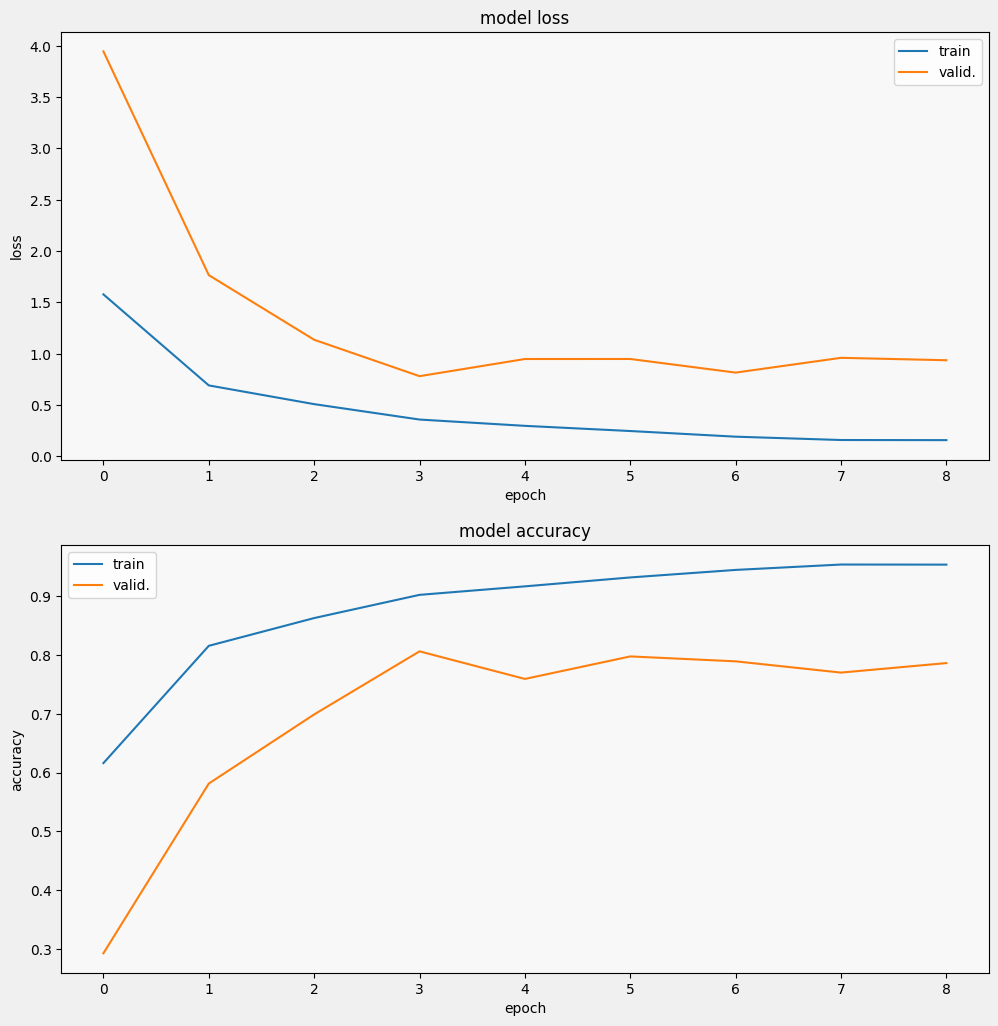

In [11]:
data_vis.display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211
)
data_vis.display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212
)

In [12]:
np.save(f'history_{model_name}.npy',history.history)
model.save(f'model_{model_name}.h5')

## Confusion matrix

In [13]:
from sklearn.metrics import confusion_matrix

# Load validation dataset from DataLoad object
cmdataset = data_load.get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

# Get correct labels and model predictions
cm_correct_labels = next(iter(labels_ds.batch(data_load.NUM_VALIDATION_IMAGES))).numpy()
cm_probabilities = model.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

# Compute confusion matrix and normalize
labels = range(len(data_load.CLASSES))
cmat = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)
cmat = (cmat.T / cmat.sum(axis=1)).T


2023-05-12 16:15:21.079676: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


2023-05-12 16:15:21.581779: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


      1/Unknown - 27s 27s/step

      2/Unknown - 27s 69ms/step

      3/Unknown - 27s 71ms/step

      4/Unknown - 27s 70ms/step

      5/Unknown - 27s 71ms/step

      6/Unknown - 27s 72ms/step

      7/Unknown - 27s 72ms/step

      8/Unknown - 27s 71ms/step

      9/Unknown - 27s 71ms/step

     10/Unknown - 27s 71ms/step

     11/Unknown - 27s 72ms/step

     12/Unknown - 27s 72ms/step

     13/Unknown - 28s 71ms/step

     14/Unknown - 28s 71ms/step

     15/Unknown - 28s 71ms/step

     16/Unknown - 28s 71ms/step

     17/Unknown - 28s 71ms/step

     18/Unknown - 28s 71ms/step

     19/Unknown - 28s 71ms/step

     20/Unknown - 28s 71ms/step

     21/Unknown - 28s 71ms/step

     22/Unknown - 28s 71ms/step

     23/Unknown - 28s 71ms/step

     24/Unknown - 28s 71ms/step

     25/Unknown - 28s 71ms/step

     26/Unknown - 28s 71ms/step

     27/Unknown - 29s 71ms/step

     28/Unknown - 29s 70ms/step

     29/Unknown - 29s 70ms/step

29/29 [==============================] - 29s 76ms/step


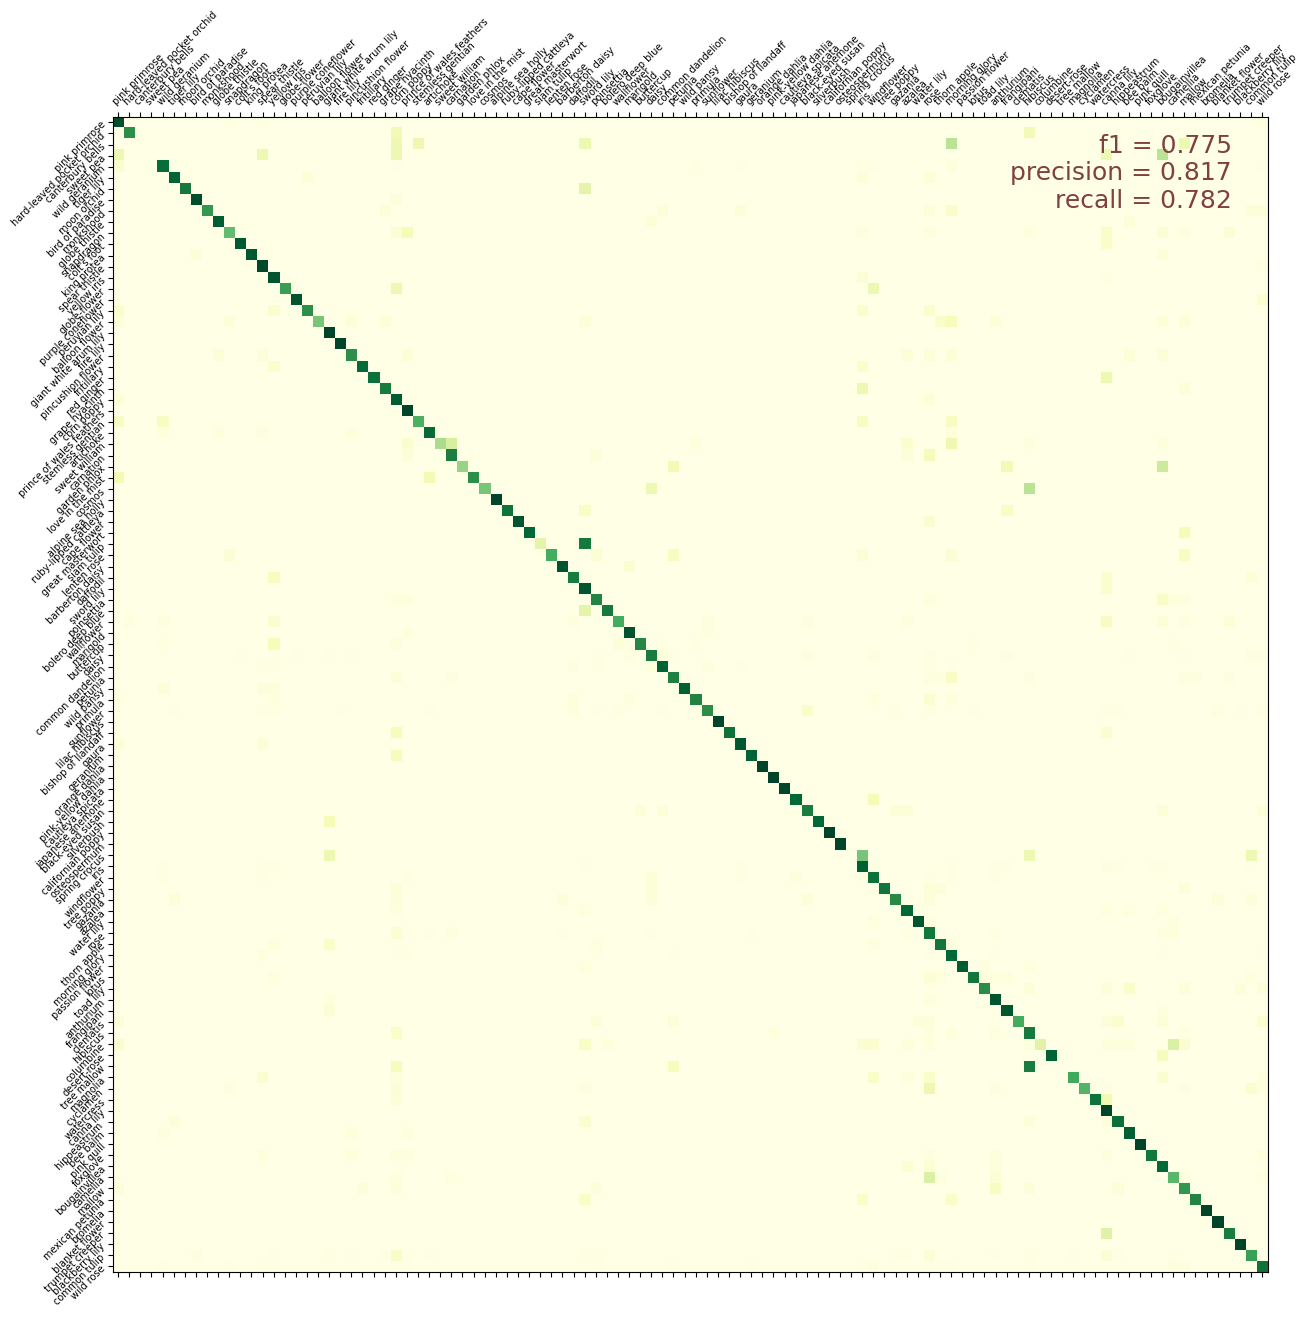

In [14]:

from sklearn.metrics import f1_score, precision_score, recall_score

score = f1_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
precision = precision_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
recall = recall_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
data_vis.display_confusion_matrix(cmat, score, precision, recall)


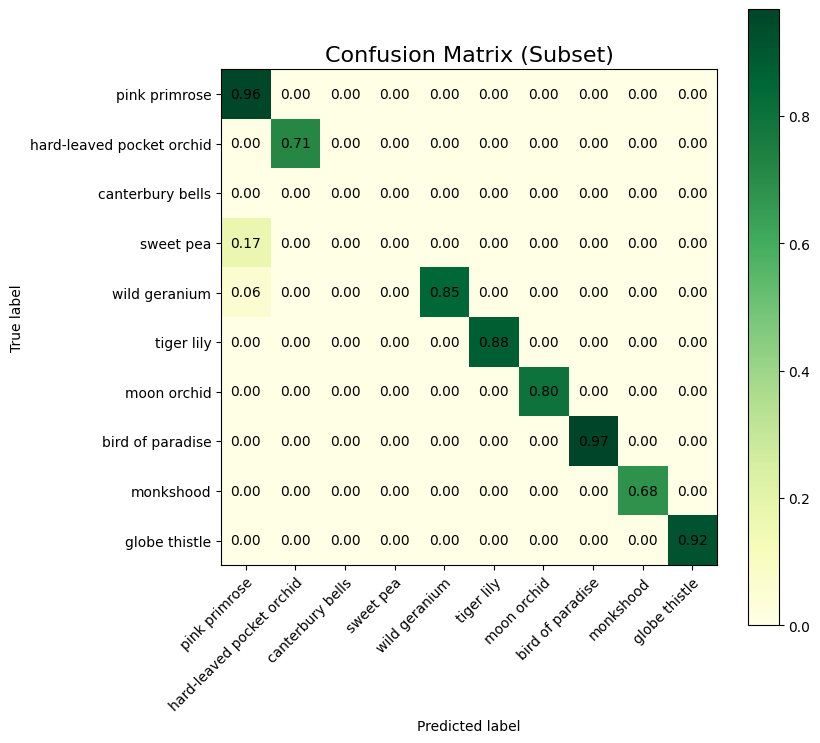

In [15]:

#Since the entire matrix is too large to be visualised at once I made an example subset of it

# Define class names
class_names = data_load.CLASSES[:10]

# Get confusion matrix for first 10 classes
cmat_subset = cmat[:10, :10]

# Normalize confusion matrix
#cmat_subset = (cmat_subset.T / cmat_subset.sum(axis=1)).T

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cmat_subset, cmap='YlGn')

# Show all ticks
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))

# Label ticks with class names
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

# Rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Axis names
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

# Loop over data dimensions and create text annotations.
for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax.text(j, i, "{:.2f}".format(cmat_subset[i, j]),
                       ha="center", va="center", color="black")

# Set plot title and colorbar
ax.set_title("Confusion Matrix (Subset)", fontsize=16)
plt.colorbar(im)
plt.show()


## Visual validation

In [16]:

dataset = cmdataset.unbatch().batch(20)
batch = iter(dataset)


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 25s 25s/step


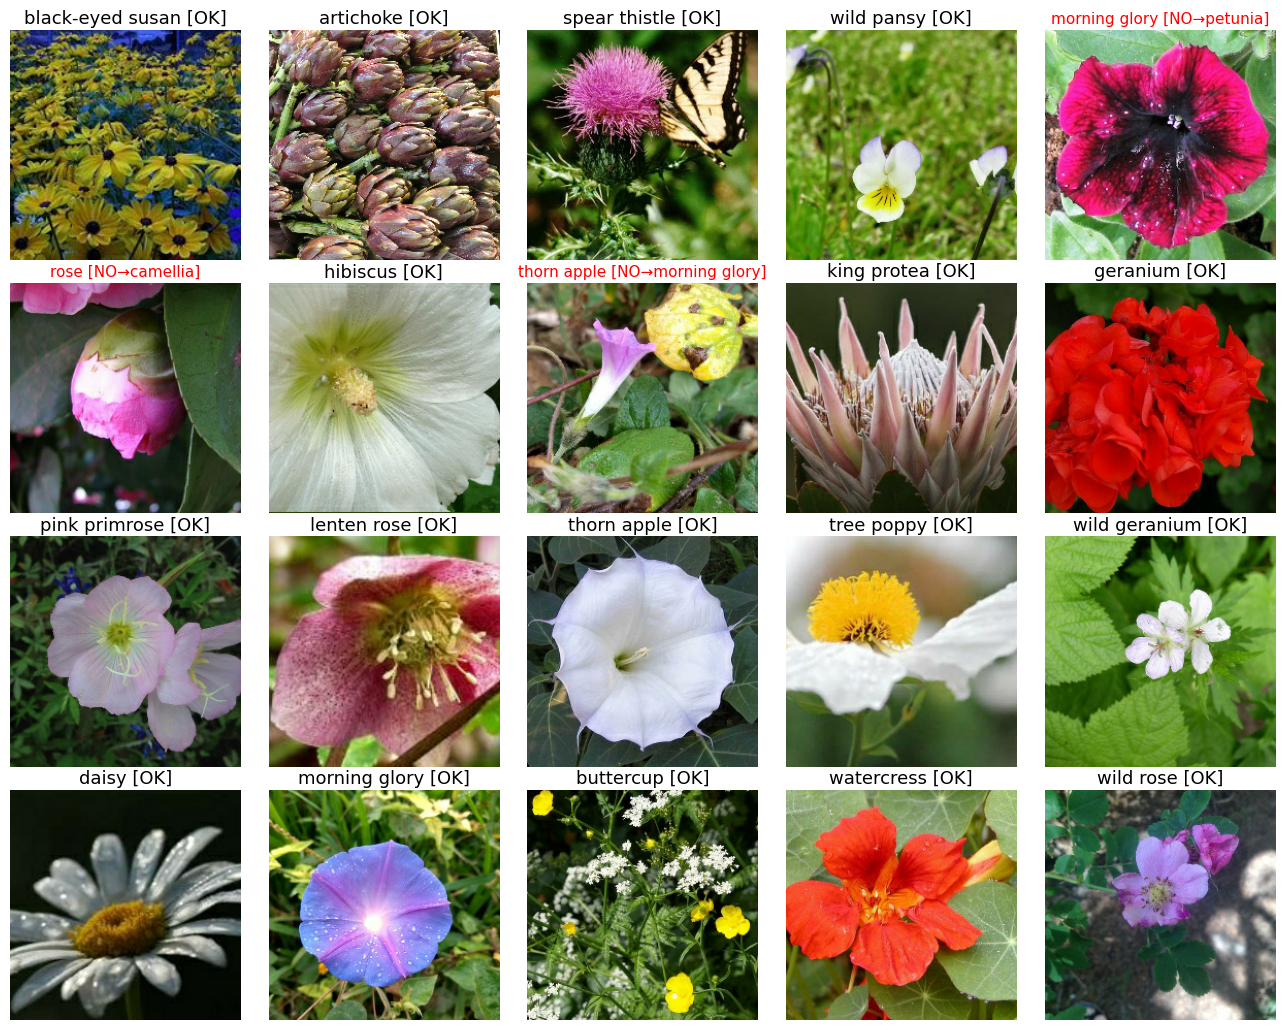

In [17]:

images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
data_vis.display_batch_of_images((images, labels), predictions)


# Predictions to submit

In [18]:
print('Computing predictions...')
test_images_ds = ds_test.map(lambda image, idnum: image).batch(BATCH_SIZE)
probabilities = model.predict(test_images_ds, steps=data_load.TEST_STEPS_PER_EPOCH+1)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

Computing predictions...


 1/58 [..............................] - ETA: 31s

 2/58 [>.............................] - ETA: 4s 

 3/58 [>.............................] - ETA: 4s

 4/58 [=>............................] - ETA: 4s

 5/58 [=>............................] - ETA: 4s

 6/58 [==>...........................] - ETA: 3s

 7/58 [==>...........................] - ETA: 3s

 8/58 [===>..........................] - ETA: 3s

 9/58 [===>..........................] - ETA: 3s

10/58 [====>.........................] - ETA: 3s

11/58 [====>.........................] - ETA: 3s

12/58 [=====>........................] - ETA: 3s

13/58 [=====>........................] - ETA: 3s

14/58 [======>.......................] - ETA: 3s

15/58 [======>.......................] - ETA: 3s

16/58 [=======>......................] - ETA: 3s

17/58 [=======>......................] - ETA: 3s

18/58 [========>.....................] - ETA: 3s

19/58 [========>.....................] - ETA: 2s

20/58 [=========>....................] - ETA: 2s

21/58 [=========>....................] - ETA: 2s

22/58 [==========>...................] - ETA: 2s

23/58 [==========>...................] - ETA: 2s

24/58 [===========>..................] - ETA: 2s

25/58 [===========>..................] - ETA: 2s

26/58 [============>.................] - ETA: 2s

27/58 [============>.................] - ETA: 2s

28/58 [=============>................] - ETA: 2s

29/58 [==============>...............] - ETA: 2s

30/58 [==============>...............] - ETA: 2s

31/58 [===============>..............] - ETA: 2s

32/58 [===============>..............] - ETA: 1s

33/58 [================>.............] - ETA: 1s

34/58 [================>.............] - ETA: 1s

35/58 [=================>............] - ETA: 1s

36/58 [=================>............] - ETA: 1s

37/58 [==================>...........] - ETA: 1s

38/58 [==================>...........] - ETA: 1s

39/58 [===================>..........] - ETA: 1s

40/58 [===================>..........] - ETA: 1s

41/58 [====================>.........] - ETA: 1s

42/58 [====================>.........] - ETA: 1s

43/58 [=====================>........] - ETA: 1s

44/58 [=====================>........] - ETA: 1s

45/58 [======================>.......] - ETA: 0s

46/58 [======================>.......] - ETA: 0s

47/58 [=======================>......] - ETA: 0s

48/58 [=======================>......] - ETA: 0s

49/58 [========================>.....] - ETA: 0s

50/58 [========================>.....] - ETA: 0s

51/58 [=========================>....] - ETA: 0s

52/58 [=========================>....] - ETA: 0s

53/58 [==========================>...] - ETA: 0s

54/58 [==========================>...] - ETA: 0s

55/58 [===========================>..] - ETA: 0s

56/58 [===========================>..] - ETA: 0s

57/58 [============================>.] - ETA: 0s

58/58 [==============================] - ETA: 0s

58/58 [==============================] - 5s 76ms/step


[ 73  81 102 ...  53  41 102]


In [19]:
print('Generating submission.csv file...')
test_ids_ds = ds_test.map(lambda image, idnum: idnum)
test_ids = next(iter(test_ids_ds.batch(data_load.NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt(f'submission_{model_name}.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')

Generating submission.csv file...


# Submitting

If you haven't already, create your own editable copy of this notebook by clicking on the Copy and Edit button in the top right corner. Then, submit to the competition by following these steps:

1. Begin by clicking on the blue Save Version button in the top right corner of the window. This will generate a pop-up window.
2. Ensure that the Save and Run All option is selected, and then click on the blue Save button.
3. This generates a window in the bottom left corner of the notebook. After it has finished running, click on the number to the right of the Save Version button. This pulls up a list of versions on the right of the screen. Click on the ellipsis (...) to the right of the most recent version, and select Open in Viewer. This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the Output tab on the right of the screen. Then, click on the file you would like to submit, and click on the blue Submit button to submit your results to the leaderboard.

You have now successfully submitted to the competition!